Parte 1
===

In [1]:
# !pip install pandas-profiling --user
# !pip install imbalanced-learn==0.10.0 --user

In [2]:
import math

import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from pandas_profiling import ProfileReport

from scipy.stats.stats import pearsonr

from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.impute import KNNImputer

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.combine import SMOTETomek

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/Usuarios_Reparadora.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [4]:
df.head()

,Y,Pais,edad,genero,Antiguedad,nombre_estado,Tiene_creditos,Creditos,saldo_actual,saldo_vencido,...,Tarjeta_credito_saldo_vencido,%_tarjeta,Tarjeta_pagos_vencidos,Tarjeta_garantia,Vivienda_saldo_actual,Vivienda_saldo_vencido,%_vivienda,Vivienda_pagos_vencidos,Vivienda_garantia,Garantia
0,0,CO,59.0,FEMENINO,Menos de 6 meses,NaN,1,4,1165000.0,1165000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,0,CO,34.0,MASCULINO,Menos de 6 meses,NaN,1,5,14176000.0,13750000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,0,CO,33.0,MASCULINO,Menos de 6 meses,NaN,1,3,624000.0,624000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,0,CO,36.0,MASCULINO,Menos de 6 meses,NaN,1,9,7109000.0,4781000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,0,CO,41.0,MASCULINO,de 6 meses a 1 año,NaN,1,15,1737999.0,1688999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [5]:
df.tail()

,Y,Pais,edad,genero,Antiguedad,nombre_estado,Tiene_creditos,Creditos,saldo_actual,saldo_vencido,...,Tarjeta_credito_saldo_vencido,%_tarjeta,Tarjeta_pagos_vencidos,Tarjeta_garantia,Vivienda_saldo_actual,Vivienda_saldo_vencido,%_vivienda,Vivienda_pagos_vencidos,Vivienda_garantia,Garantia
2891,0,CO,30.0,FEMENINO,Menos de 6 meses,NaN,1,6,155000.0,60000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2892,0,CO,51.0,FEMENINO,Menos de 6 meses,NaN,1,21,1821000.0,1199000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2893,0,CO,30.0,FEMENINO,Menos de 6 meses,NaN,1,3,1370000.0,831000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2894,0,CO,NaN,FEMENINO,de 6 meses a 1 año,Santander,1,2,2274000.0,2169000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2895,0,CO,22.0,MASCULINO,de 6 meses a 1 año,NaN,1,2,3419000.0,0.0,...,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0


## 1. Análisis exploratorio de los datos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Y                              2896 non-null   int64  
 1   Pais                           2896 non-null   object 
 2   edad                           2718 non-null   float64
 3   genero                         2896 non-null   object 
 4   Antiguedad                     2896 non-null   object 
 5   nombre_estado                  122 non-null    object 
 6   Tiene_creditos                 2896 non-null   int64  
 7   Creditos                       2896 non-null   int64  
 8   saldo_actual                   2893 non-null   float64
 9   saldo_vencido                  2893 non-null   float64
 10  mop_historico                  2721 non-null   object 
 11  numero_pagos_vencidos          1137 non-null   float64
 12  Promedio de limite_credito     1820 non-null   f

El reporte anterior permite identificar campos con **alto porcentaje de valores nulos o missing**. La idea es eliminados del conjunto de datos, ya que por insuficiencia de información, no aportan valor en el modelado; sin embargo, esa decisión se tomará luego de explorar la información.

In [7]:
missing_data = df.isna().sum() / df.shape[0]
missing_data.describe()

count    81.000000
mean      0.564163
std       0.431328
min       0.000000
25%       0.020028
50%       0.830456
75%       0.977901
max       0.999655
dtype: float64

<AxesSubplot:>

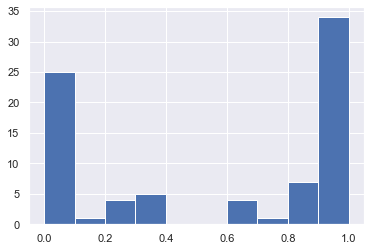

In [8]:
missing_data.hist()

La primera regla de limpieza, antes de continuar con el análisis exploratorio, será eliminar las características que tengan un porcentaje de valores nulos o perdidos **superior al 56.4%** correspondiente al valor de la media. Esto eliminará de entrada el **50% de las características aproximadamente** y nos evitará en el futuro posibles sesgos en el modelado.

### Eliminación de características *missing*

In [9]:
missing = missing_data > missing_data.describe()['mean']
print(f"Cantidad de columnas missing: {missing[missing].shape[0]}")
print(f"Nombres de columnas missing:\n{', '.join(missing[missing].index.tolist())}")

Cantidad de columnas missing: 46
Nombres de columnas missing:
nombre_estado, numero_pagos_vencidos, sistema_operativo, Desinstalaciones, Activo_saldo_actual, Activo_saldo_vencido, %_Activo, Activos_pagos_vencidos, Activos_garantia, Autos_saldo_actual, Autos_saldo_vencido, %_Autos, Autos_pagos_vencidos, Autos_garantia, Comunicaciones_pagos_vencidos, consumo_pagos_vencidos, Educacion_saldo_actual, Educacion_saldo_vencido, %_educuacion, Educacion_pagos_vencidos, Educacion_garantia, Libranza_saldo_actual, Libranza_saldo_vencido, %_libranza, Libranza_pagos_vencidos, Libranza_garantia, Microcredito_saldo_actual, Microcredito_saldo_vencido, %_microcredito, microcredito_pagos_vencidos, microcredito_garantia, Otros_saldo_actual, Otros_saldo_vencido, %_otro, Otros_pagos_vencidos, Otros_garantia, Tarjeta_credito_saldo_actual, Tarjeta_credito_saldo_vencido, %_tarjeta, Tarjeta_pagos_vencidos, Tarjeta_garantia, Vivienda_saldo_actual, Vivienda_saldo_vencido, %_vivienda, Vivienda_pagos_vencidos, Vivie

In [10]:
no_missing = missing_data <= missing_data.describe()['mean']
no_missing_columns = no_missing[no_missing].index.tolist()
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")
print(f"Nombres de columnas seleccionadas no missing: {', '.join(no_missing_columns)}")

Cantidad de columnas seleccionadas no missing: 35
Nombres de columnas seleccionadas no missing: Y, Pais, edad, genero, Antiguedad, Tiene_creditos, Creditos, saldo_actual, saldo_vencido, mop_historico, Promedio de limite_credito, Promedio de credito_maximo, Promedio de cantidad_cuotas, Promedio de valor_cuota, ahorro_impacto, bienestar_financiero_impacto, coaching_impacto, gestion_de_gastos_impacto, score, perfil_usuario, Tiene_ahorro, monto_ahorro, monto_bloqueado, monto_total, Tiene_seguros, Seguros, Comunicaciones_saldo_actual, Comunicaciones_saldo_vencido, %_comunicaciones, Comunicaciones_garantia, Consumo_saldo_actual, Consumo_saldo_vencido, %_consumo, consumo_garantia, Garantia


Podemos observar que **35 características** cumplen con el criterio de valores nulos o perdidos. Vamos a aplicar este cambio en el conjunto de datos original y a continuar con el proceso de **Perfilamiento de los datos**

In [11]:
df = df[no_missing_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Y                             2896 non-null   int64  
 1   Pais                          2896 non-null   object 
 2   edad                          2718 non-null   float64
 3   genero                        2896 non-null   object 
 4   Antiguedad                    2896 non-null   object 
 5   Tiene_creditos                2896 non-null   int64  
 6   Creditos                      2896 non-null   int64  
 7   saldo_actual                  2893 non-null   float64
 8   saldo_vencido                 2893 non-null   float64
 9   mop_historico                 2721 non-null   object 
 10  Promedio de limite_credito    1820 non-null   float64
 11  Promedio de credito_maximo    2888 non-null   float64
 12  Promedio de cantidad_cuotas   2599 non-null   float64
 13  Pro

### Reporte de perfilamiento de los datos

Apoyandonos en el paquete *pandas-profiling*, vamos a realizar un proceso de perfilamiento de los datos, donde nos indicará la cantidad de variables, tipos de dato, clasificación de las características en categóricas, numéricas, etc. A través de este reporte en HTML tomaremos las primeras decisiones relevantes para la preparación de los datos.

In [12]:
profile = ProfileReport(df, title="Perfilamiento Usuarios Reparadora", minimal=True)
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


In [13]:
profile.to_file("profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


En términos generales, se encontraron **35 características** en el conjunto de datos, sumando la variable objetivo "Y". Un total de **5 categóricas** y **30 numéricas**. Tenemos **2896 observaciones** con un porcentaje de 9.2% valores missing y un tamaño promedio por registro de 280 bytes. A cotinuación, realizaremos un resumen del análisis exploratorio a partir del reporte generado con *pandas-profiling*, detallando las características y estadísticos más relevantes de las variables individuales.

#### Variable objetivo

Puede notarse que la variable objetivo, la cual evalúa la propensión de un usuario a ser aceptado (1) o rechazado (0) por la compañía reparadora de deudas, tiene un notable desbalance en los datos. **97.1%** (2811 registros) de los usuarios han sido rechazados, lo cual puede deberse a que las políticas de ingreso son muy exigentes con respecto a los score y/o condiciones financieras del crédito. Cualquiera que sea la explicación, nos deja solo un **2.9%** (85 registros) de los usuarios como propensos a reparación y un conjunto de datos bastante desbalanceado para el propósito de modelado. Más adelante se analizaran las alternativas para balanceo de la muestra o se eligiran modelos tolerantes a estas condiciones.

#### Variables con valor constante

Tienen un único valor constante y por tanto, no aportan mucho valor en el modelado. Haremos un análisis de cada una para verificar si tienen valores nulos, ya que la interpretación de este puede derivar en un valor por defecto que complemente el conjunto de datos.

| Columna                   | Constante | % nulos | # nulos |
|:--------------------------|:----------|:--------|:--------|
| Pais                      | CO        | 0.0%    | 0       |
| Tiene_creditos            | 1         | 0.0%    | 0       |
| Tiene_seguros             | 0         | 0.0%    | 0       |
| Seguros                   | 0         | 0.0%    | 0       |
| gestion_de_gastos_impacto | 0         | 0.1%    | 2       |
| Comunicaciones_garantia   | 1.0       | 21.2%   | 614     |
| consumo_garantia          | 1.0       | 37.1%   | 1074    |

**Variables no consideradas para el modelado:**

- Pais
- Tiene_creditos
- Tiene_seguros
- Seguros
- gestion_de_gastos_impacto

**NOTA:** El resto de las variables serán analizadas más adelante.

#### Variables categóricas no balanceadas

Una o varias categorías producen un desbalance en la muestra de datos. Se debe estudiar en este caso las categorías con pocos valores, ya que podrían agruparse con otras mayoritarias y evaluar si es necesario calcular una nueva variable.

| Columna                   | % desbalance | % nulos | # nulos |
|:--------------------------|:-------------|:--------|:--------|
| Antiguedad                | 55.4%        | 0.0%    | 0       |
| mop_historico             | 71.2%        | 6.0%    | 175     |

**Antiguedad:** *Menos de 6 meses (82.6%)* es la clase mayoritaría. *Mas de 1 año (0.7%)* tiene un porcentaje muy bajo. En la fase de ingeniería de características analizaremos más a fondo esta situación, aunque como primera medida podríamos pensar en unir las clases minoritarías.

**mop_historico:** Tiene valores enteros y un alfanumérico como la **clase mayoritaría (N: deuda al día**). Más adelante será construída una nueva variable para el nivel mop historico de tipo categórica.

#### Variables con valores missing

Corresponde a las variables que tienen valores nulos o missing. Se tomaran decisiones de imputación o eliminación de características.

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| edad                         | entero       | 6.1%    | 178     |
| mop_historico                | categórica   | 6.0%    | 175     |
| score                        | entero       | 8.4%    | 244     |
| perfil_usuario               | entero       | 8.4%    | 244     |

- edad: imputamos valores missing con la **media**, ya que tiene una distribución "cercana" a una normal y el sesgo, aunque es positivo, es un valor pequeño, al igual que la curtosis. **Valor de la media 31 años.**

- mop_historico: valores nulos serán imputados con una valor de clase por defecto: **"Sin registro"**.

- score: esta métrica viene de un sistema externo y por lo tanto no se puede imputar. En este caso se sustituyen los valores missing con: **"Sin registro"**.

- perfil_usuario: esta variable esta relacionada con el *score*, por tanto, será descartada del conjunto de datos y calculada como categórica más adelante.


#### Análisis variables tipo "promedio" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Promedio de limite_credito   | flotante     | 37.2%   | 1076    |
| Promedio de credito_maximo   | flotante     | 0.3%    | 8       |
| Promedio de cantidad_cuotas  | flotante     | 10.3%   | 297     |
| Promedio de valor_cuota      | flotante     | 0.1%    | 3       |

Antes que nada vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

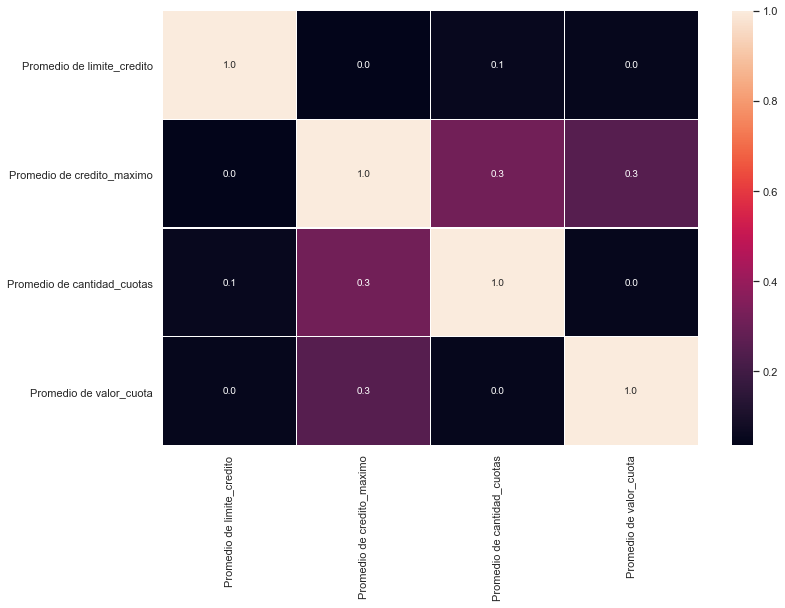

In [14]:
avg_type_columns = ['Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[avg_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que las variables no tienen ninguna relación. Procedamos entonces a definir las reglas de imputación de valores missing:

- Promedio de credito_maximo y Promedio de valor_cuota: tanto los valores en -1 como los valores missing serán imputados con el valor cero (0).

- Promedio de limite_credito: esta variable será imputada con el método de **vecinos más cercanos (kNN)**. El motivo es que al no tener correlaciones con otras variables, no se pueden aplicar los métodos de regresión.

- Promedio de cantidad_cuotas: según la distribución, tiene una cola pesada a la derecha con sesgo de 12.5. En este caso es mejor imputar con una medida de tendencia central tolerante a los valores atípicos: **mediana**. Esta tiene un valor de **3.2**.

#### Análisis de variables tipo "monto" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Tiene_ahorro                 | entero       | 0.0%    | 0       |
| monto_ahorro                 | flotante     | 0.0%    | 0       |
| monto_bloqueado              | flotante     | 2.0%    | 58      |
| monto_total                  | flotante     | 2.0%    | 58      |

Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

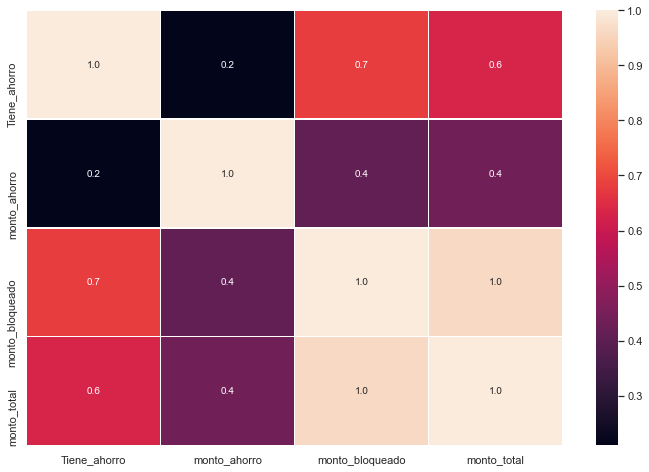

In [15]:
amount_type_columns = ['Tiene_ahorro', 'monto_ahorro', 'monto_bloqueado', 'monto_total']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[amount_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Vemos como el **monto_bloqueado** y **monto_total** tienen un factor de correlación del 100%. No se tomaran decisiones de eliminación hasta no estudiar el impacto del monto de ahorro bloqueado cuando se evalúa ingreso al programa de reparación.

Realizaremos un estudio adicional de **Tiene_ahorro** vs. **monto_total**, ya que se aprecia un factor de correlación del 60%.

<AxesSubplot:xlabel='Tiene_ahorro', ylabel='monto_total'>

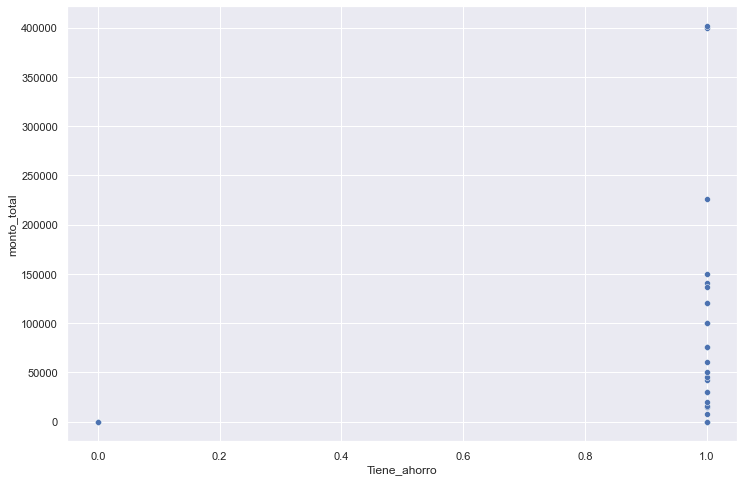

In [16]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x=df['Tiene_ahorro'], y=df['monto_total'])

Finalmente, dado que los valores missing de **monto_total y monto_bloqueado** son apenas **58 registros**, vamos a imputar esta variable con un cero (0).

#### Análisis de variables tipo "Comunicaciones" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Comunicaciones_saldo_actual  | flotante     | 21.8%   | 632     |
| Comunicaciones_saldo_vencido | flotante     | 21.8%   | 632     |
| %_comunicaciones             | flotante     | 23.5%   | 680     |
| Comunicaciones_garantia      | entero       | 21.2%   | 614     |


Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

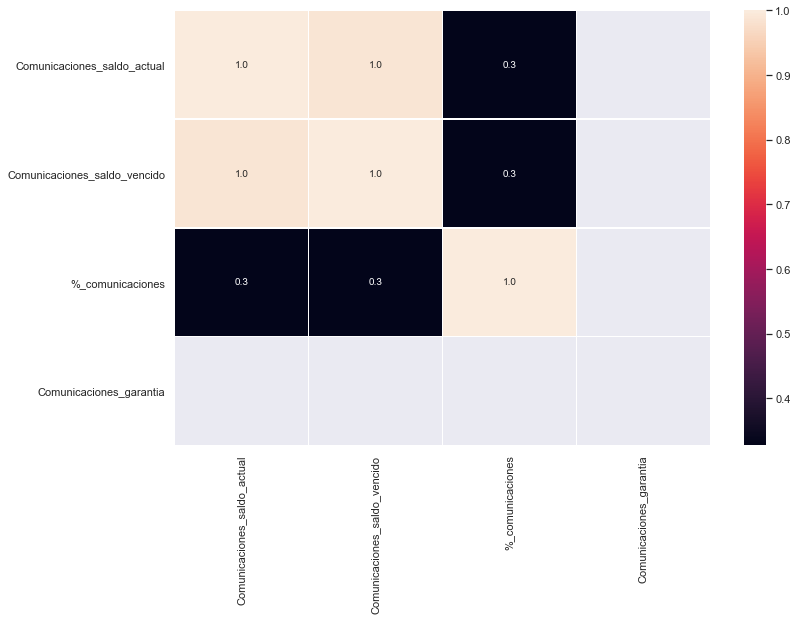

In [17]:
comm_type_columns = ['Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_garantia']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[comm_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que algunas variables tienen relación, pero no se tomarán decisiones hasta evaluar el impacto de estas. Procedamos entonces a definir las reglas de imputación:

- Comunicaciones_saldo_vencido, Comunicaciones_saldo_actual, %_comunicaciones y Comunicaciones_garantia: se realiza imputación para valores missing con cero (0).

#### Análisis de variables tipo "Consumo" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Consumo_saldo_actual         | flotante     | 37.9%   | 1098    |
| Consumo_saldo_vencido        | flotante     | 37.9%   | 1098    |
| %_consumo                    | flotante     | 38.7%   | 1120    |
| consumo_garantia             | entero       | 37.1%   | 1074    |

Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

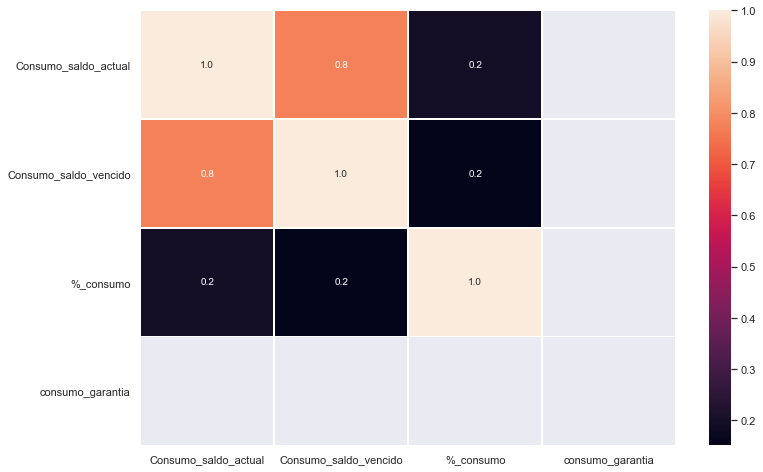

In [18]:
cons_type_columns = ['Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_garantia']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[cons_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que algunas variables tienen relación, pero no se tomarán decisiones hasta evaluar el impacto de estas. Procedamos entonces a definir las reglas de imputación:

- Consumo_saldo_vencido, Consumo_saldo_actual, %_consumo y consumo_garantia: se realiza imputación para valores missing con cero (0).

#### Análisis de variables tipo "Crédito" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Creditos                     | entero       | 0.0%    | 0       |
| saldo_actual                 | flotante     | 0.1%    | 3       |
| saldo_vencido                | flotante     | 0.1%    | 3       |

Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

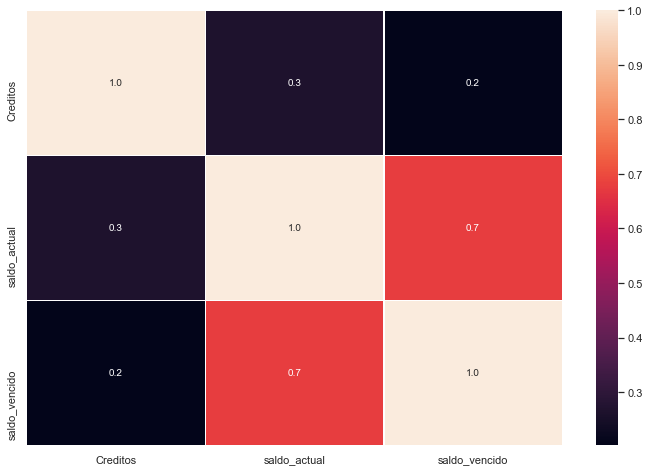

In [19]:
credit_type_columns = ['Creditos', 'saldo_actual', 'saldo_vencido']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[credit_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que algunas variables tienen relación, pero no se tomarán decisiones hasta evaluar el impacto de estas. Procedamos entonces a definir las reglas de imputación:

- saldo_actual y saldo_vencido: se realiza imputación para valores missing con cero (0).

### Análisis exploratorio multivariable

A continuación, vamos a realizar análisis puntuales sobre combinaciones de características, buscando algunos patrones en los datos que nos permitan tomar decisiones para la limpieza, estandarización y preparación de los datos.

In [20]:
df.columns.shape

(35,)

#### Análisis de variable objetivo con edad y genero

<AxesSubplot:xlabel='genero', ylabel='edad'>

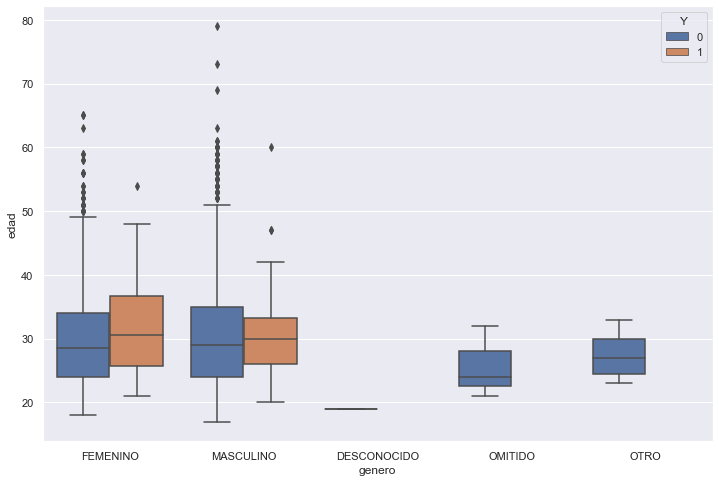

In [21]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="genero", y="edad", hue="Y")

<AxesSubplot:xlabel='genero', ylabel='edad'>

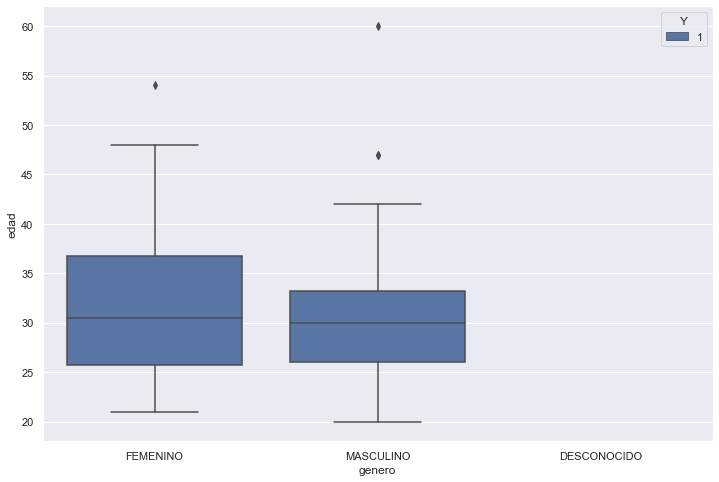

In [22]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df[df.Y == 1], x="genero", y="edad", hue="Y")

Vemos que los casos de usuarios propensos a reparación se distribuyen exclusivamente en los generos **FEMENINO** y **MASCULINO**. La edad promedio para entrar al programa de reparación en ambos generos es **30 años** aproximadamente y es evidente como las mujeres tienen un rango de edad más amplio para ser marcadas como aceptado. Además, notese el rango de edades para aceptados entre 25 y 35 años aproximadamente.

Es fáctible que los otros generos se integren en **OTRO**, no justifica tenerlos dispersos. Por tanto, los valores **DESCONOCIDO** y **OMITIDO** serán modificados por el valor indicado.

Identificamos 3 rangos etáreos claros. Usuarios entre la edad mínima y los 25 años, de 25 a 37 años y de 37 en adelante. Podemos construir intencionalmente estos rangos y convertir la edad en una categórica.

#### Análisis de variable obetivo con antiguedad, mop y score

<AxesSubplot:xlabel='Antiguedad', ylabel='score'>

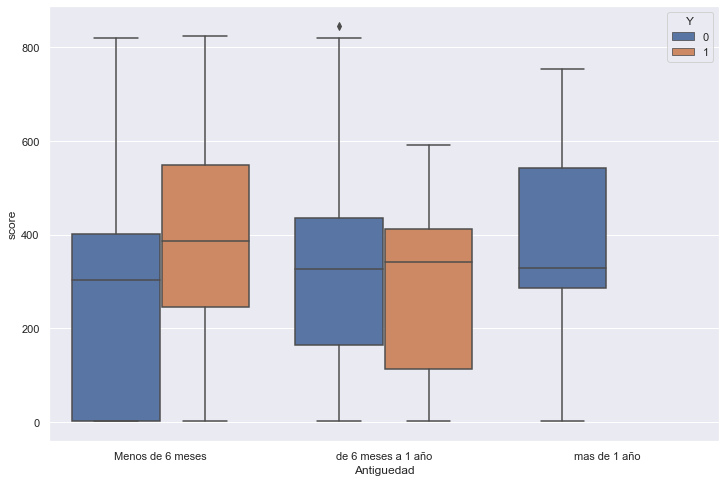

In [23]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="Antiguedad", y="score", hue="Y")

Vemos en general que la mayopría de los usuarios que han sido evaluadas para ingresar a reparación, no superan un score de **600 puntos**, lo cual indica que aquellos que buscan este programa necesitan alivios financieros. Justamente, los usuarios más antiguos que fueron aceptados tienen los score más bajos.

El valor de antiguedad "mas de 1 año" efectivamente puede integrarse con el valor "de 6 meses a 1 año".

<AxesSubplot:xlabel='mop_historico', ylabel='score'>

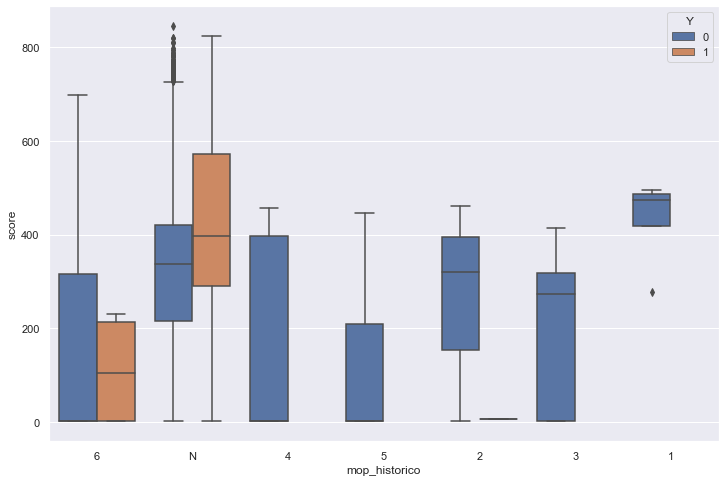

In [24]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="mop_historico", y="score", hue="Y")

Es posible notar como el score baja o tiende a bajar cuando aumenta el MOP histórico, es decir, a medida que las personas acumulan días de mora, el score comienza a decender paulatinamente.

Vemos que usuarios aceptados en el programa y que se encuentran al día tienen los score promedio más altos, lo que indica que una persona con buen comportamienta tiene alta posibilidad de ingresar a reparación. Por otro lado, quienes tienen las deudas más atrasadas, en el MOP histórico mayor a 120 días, también tienen oportunidad de ingresar y son candidatos considerados por su bajo score crediticio.

Dado que algunos valores de MOP histórico no tienen lugar en la decisión de ser aceptado o rechazado, vamos a integrar los MOP con valor 1, 2, 3, 4 en un único rango llamado "Mora 30 a 120 días".

#### Análisis de variable objetivo con saldo actual y vencido (usando mop)

<AxesSubplot:xlabel='saldo_actual', ylabel='saldo_vencido'>

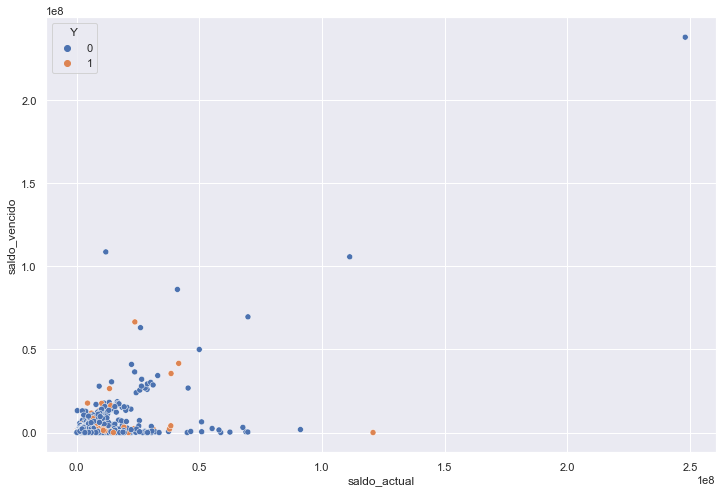

In [25]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="saldo_actual", y="saldo_vencido", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='saldo_actual'>

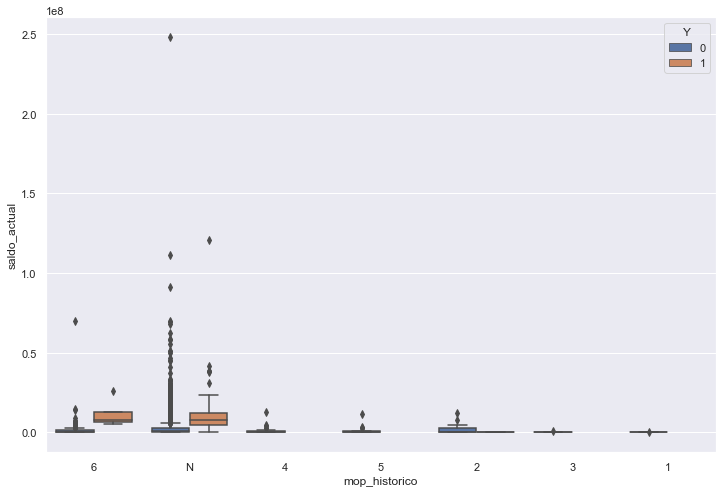

In [26]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="mop_historico", y="saldo_actual", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='saldo_vencido'>

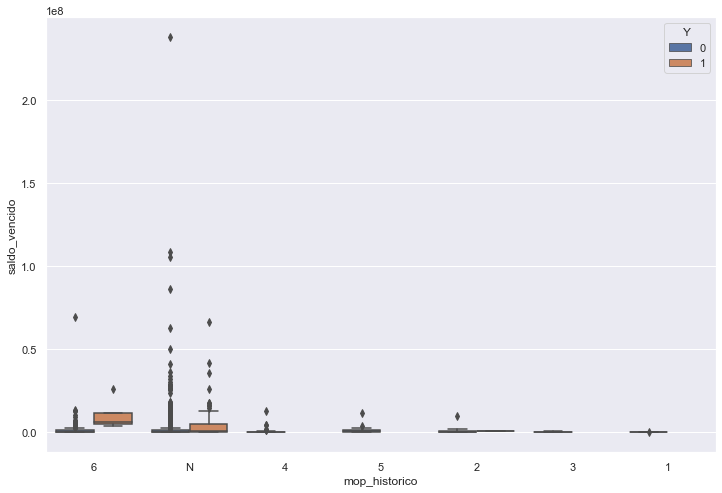

In [27]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="mop_historico", y="saldo_vencido", hue="Y")

No existe un patrón claro, pero podemos notar que el saldo actual y vencido tiene valores promedio más altos para las usuarios que fueron aceptados en reparación. Por tanto, estas variables son muy importantes para el modelado.

#### Análisis variable objetivo con límite crédito y crédito máximo

<AxesSubplot:xlabel='Promedio de limite_credito', ylabel='Promedio de credito_maximo'>

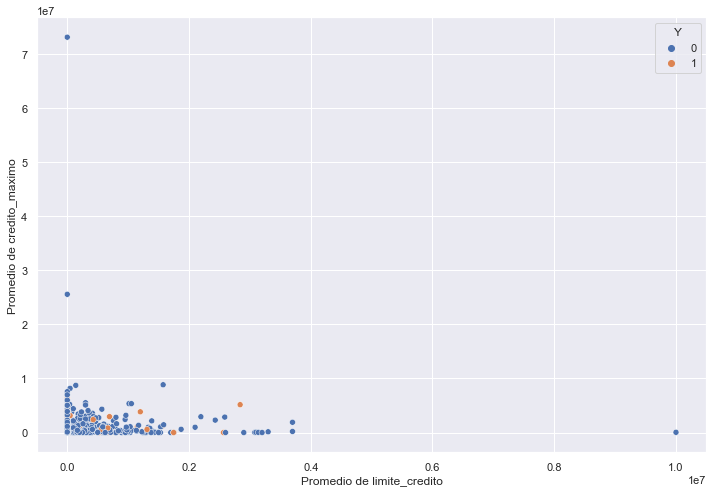

In [28]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="Promedio de limite_credito", y="Promedio de credito_maximo", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='Promedio de limite_credito'>

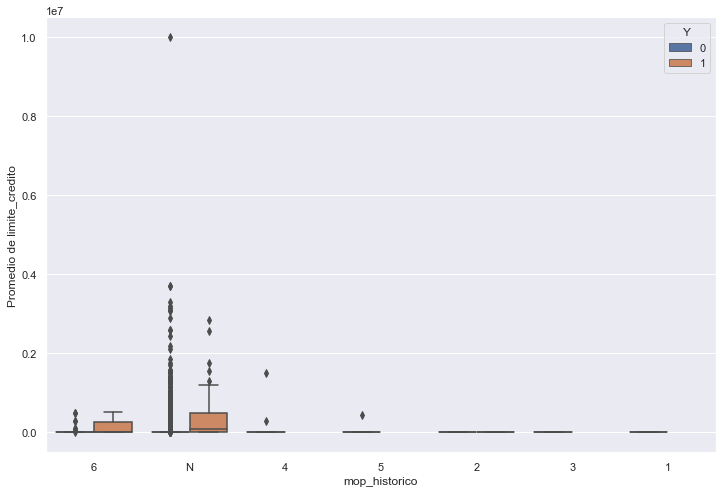

In [29]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="mop_historico", y="Promedio de limite_credito", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='Promedio de credito_maximo'>

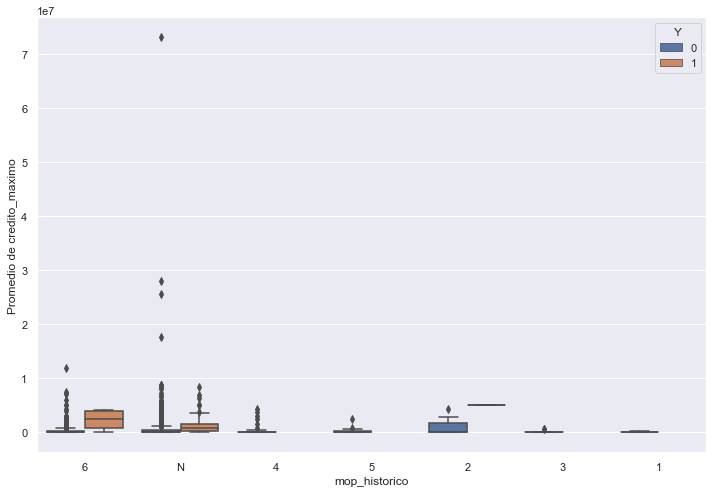

In [30]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="mop_historico", y="Promedio de credito_maximo", hue="Y")

Notese que los valores más altos de estos promedios son para los usuarios aceptados. En efecto, estas variables se seguiran considerando en el modelado.

#### Análisis variable objetivo con monto ahorro y bloqueado

<AxesSubplot:xlabel='monto_ahorro', ylabel='monto_total'>

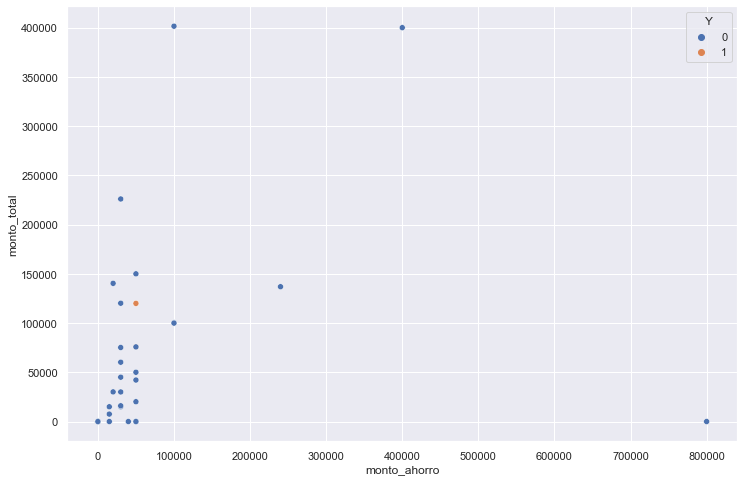

In [31]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="monto_ahorro", y="monto_total", hue="Y")

<AxesSubplot:xlabel='monto_bloqueado', ylabel='monto_total'>

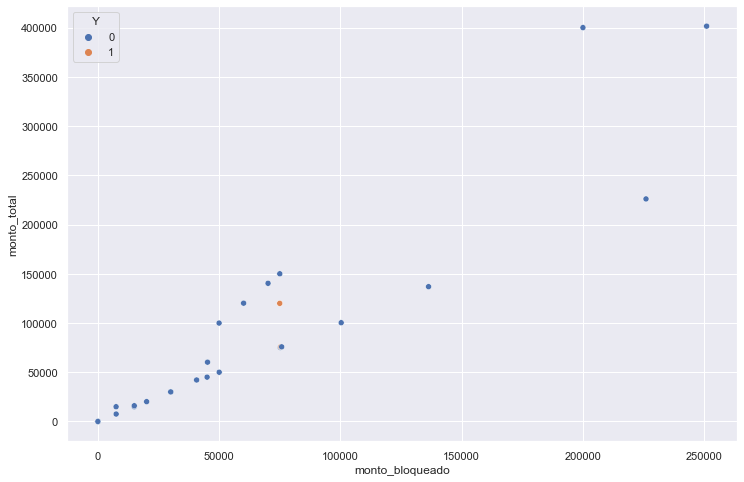

In [32]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="monto_bloqueado", y="monto_total", hue="Y")

<AxesSubplot:xlabel='Tiene_ahorro', ylabel='monto_ahorro'>

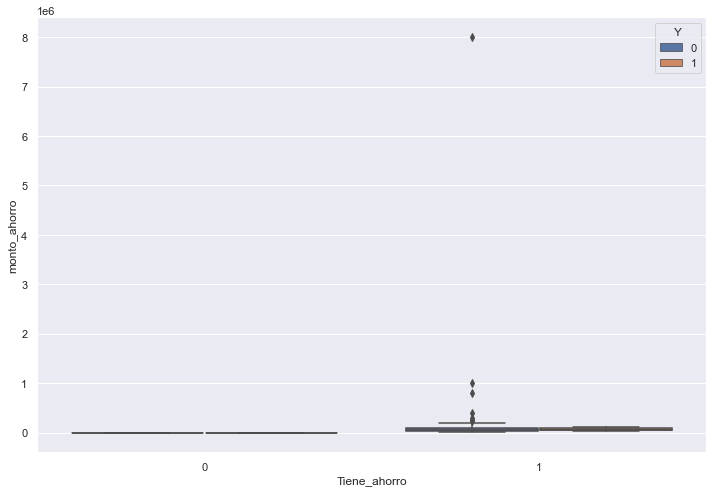

In [33]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="Tiene_ahorro", y="monto_ahorro", hue="Y")

<AxesSubplot:xlabel='Tiene_ahorro', ylabel='monto_total'>

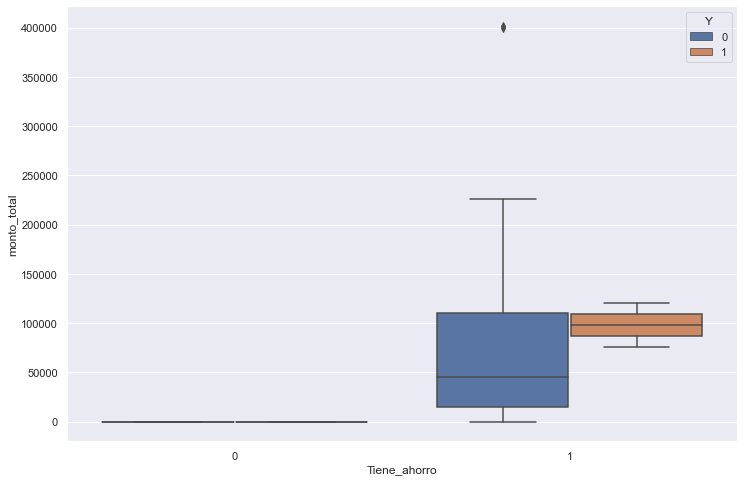

In [34]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="Tiene_ahorro", y="monto_total", hue="Y")

Podemos apreciar que monto_ahorro no tiene relación con monto_bloqueado y monto_total. Estas dos últimas si tienen una estrecha relación lineal y por tanto, vamos a considerar para modelado **monto_total**.

El análisis indica que los usuarios tienen más probabilidad de entrar al programa si tienen un valor de ahorro y esto permite hacer el descarte de la variable booleana **Tiene_ahorro**, ya que con monto_ahorro y monto_total se agrega el comportamiento necesario en el modelado.

#### Análisis variable objetivo con "Comunicaciones"

<AxesSubplot:xlabel='Comunicaciones_saldo_actual', ylabel='Comunicaciones_saldo_vencido'>

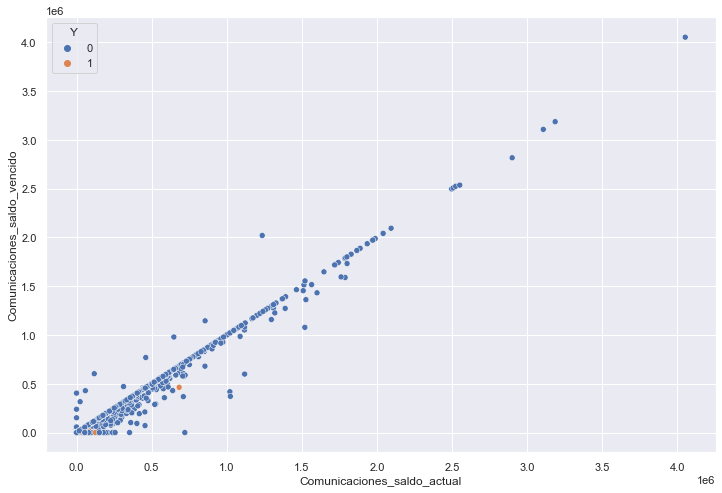

In [35]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="Comunicaciones_saldo_actual", y="Comunicaciones_saldo_vencido", hue="Y")

<AxesSubplot:xlabel='Comunicaciones_saldo_actual', ylabel='%_comunicaciones'>

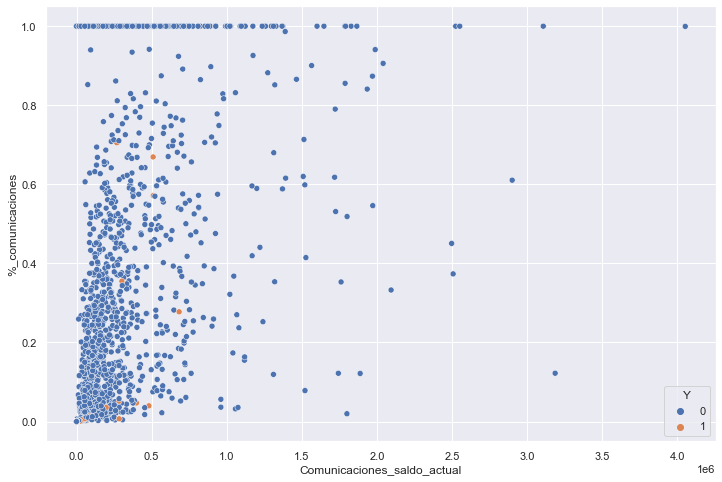

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="Comunicaciones_saldo_actual", y="%_comunicaciones", hue="Y")

<AxesSubplot:xlabel='Comunicaciones_garantia', ylabel='Comunicaciones_saldo_actual'>

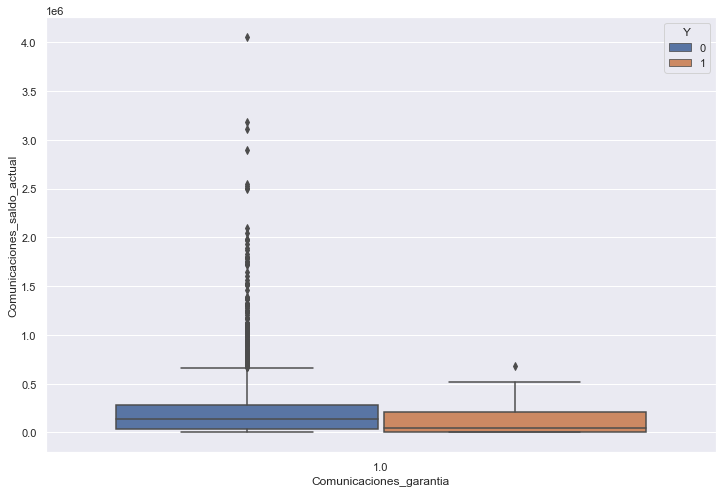

In [37]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="Comunicaciones_garantia", y="Comunicaciones_saldo_actual", hue="Y")

In [38]:
print(df[df.Y == 0]['Comunicaciones_garantia'].value_counts())
print(df[df.Y == 1]['Comunicaciones_garantia'].value_counts())

1.0    2228
Name: Comunicaciones_garantia, dtype: int64
1.0    54
Name: Comunicaciones_garantia, dtype: int64


Lo primero es que estas variables no tienen una incidencia clara sobre la decisión de aceptar o rechazar un usuario. Hay un comportamiento equilibrado. Además, aún tienen valores nulos que imputar en una proporción media de 22%.

Vamos a descartar estas variables del modelado: Comunicaciones_saldo_actual, Comunicaciones_saldo_vencido, %_comunicaciones, Comunicaciones_garantia.

#### Análisis variable objetivo con "Consumo"

<AxesSubplot:xlabel='Consumo_saldo_actual', ylabel='Consumo_saldo_vencido'>

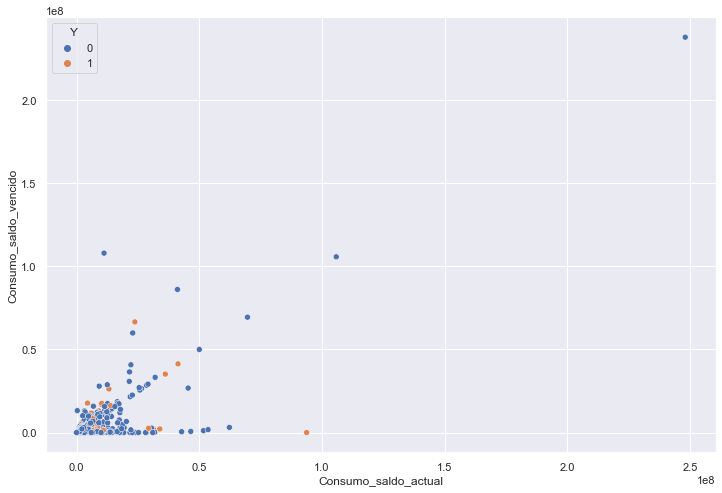

In [39]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="Consumo_saldo_actual", y="Consumo_saldo_vencido", hue="Y")

<AxesSubplot:xlabel='Consumo_saldo_actual', ylabel='%_consumo'>

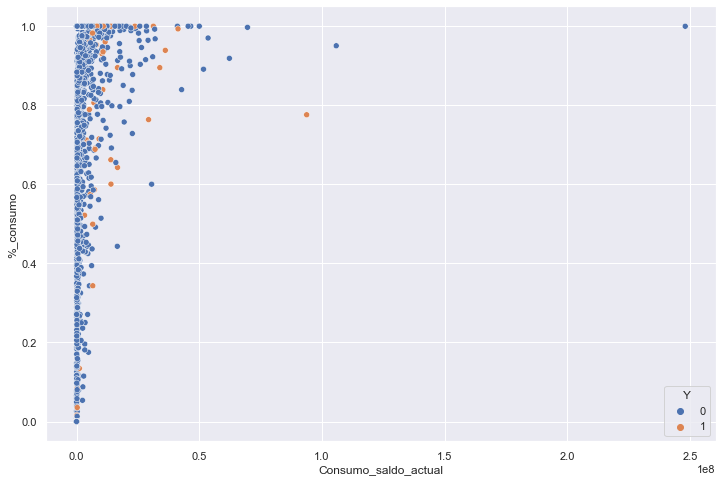

In [40]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x="Consumo_saldo_actual", y="%_consumo", hue="Y")

<AxesSubplot:xlabel='consumo_garantia', ylabel='Consumo_saldo_actual'>

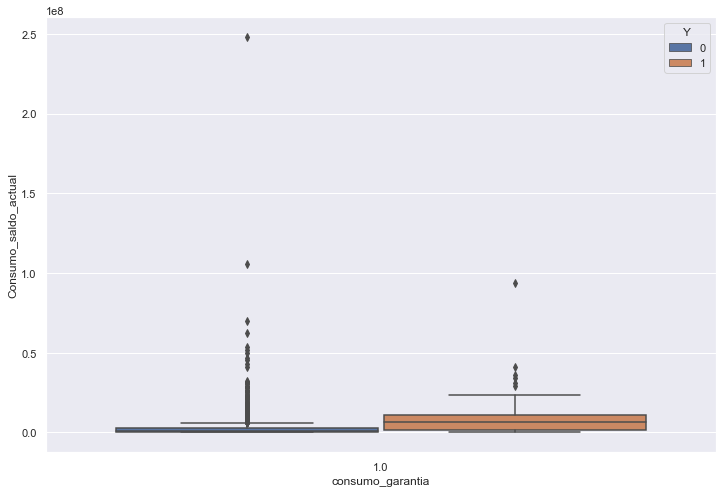

In [41]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df, x="consumo_garantia", y="Consumo_saldo_actual", hue="Y")

Lo primero es que estas variables no tienen una incidencia clara sobre la decisión de aceptar o rechazar un usuario. Hay un comportamiento equilibrado. Además, aún tienen valores nulos que imputar en una proporción media de 37%.

Vamos a descartar estas variables del modelado: Consumo_saldo_actual, Consumo_saldo_vencido, %_consumo y consumo_garantia.

##  2. Ingeniería de características

### Limpieza de los datos

In [42]:
columns_to_remove = [
    'Pais', 'Tiene_creditos', 'Tiene_seguros', 'Seguros', 'perfil_usuario', 'Tiene_ahorro', 'monto_bloqueado', 'gestion_de_gastos_impacto',
    'Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_garantia', 
    'Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_garantia',
]

columns_with_negatives = [
    'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 
    'Promedio de cantidad_cuotas', 'Promedio de valor_cuota',
]

columns_to_fill_with_zero = [
    'saldo_actual', 'saldo_vencido', 'Promedio de credito_maximo', 'Promedio de valor_cuota',
    'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'monto_ahorro', 'monto_total',
]

In [43]:
clean_df = df.copy()

In [44]:
# Eliminamos las características que no serán requeridas
clean_df = clean_df.drop(columns=columns_to_remove)
clean_df.shape

(2896, 19)

In [45]:
# Reemplazamos valores negativos en características numéricas por NULO
# y luego los valores nulos por cero (0)

for column in columns_with_negatives:
    clean_df[column] = clean_df[column].apply(lambda x: np.nan if x < 0 else x)
    
for column in columns_to_fill_with_zero:
    clean_df[column] = clean_df[column].fillna(0)

In [46]:
clean_df[columns_to_fill_with_zero].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
saldo_actual,2896.0,2.932009e+06,8.291932e+06,0.0,279750.0,756499.5,2422000.00,2.480190e+08
saldo_vencido,2896.0,1.735882e+06,6.784136e+06,0.0,161750.0,469000.0,1267000.00,2.380350e+08
Promedio de credito_maximo,2896.0,5.452882e+05,1.847657e+06,0.0,0.0,119708.5,514305.25,7.315213e+07
Promedio de valor_cuota,2896.0,2.155279e+05,8.545303e+05,0.0,19333.0,58243.0,149208.50,2.220000e+07
ahorro_impacto,2896.0,1.174033e-02,1.077335e-01,0.0,0.0,0.0,0.00,1.000000e+00
bienestar_financiero_impacto,2896.0,1.035912e-03,3.217446e-02,0.0,0.0,0.0,0.00,1.000000e+00
coaching_impacto,2896.0,1.933702e-02,1.377303e-01,0.0,0.0,0.0,0.00,1.000000e+00
monto_ahorro,2896.0,5.595649e+03,1.514954e+05,0.0,0.0,0.0,0.00,8.000000e+06
monto_total,2896.0,8.472290e+02,1.327552e+04,0.0,0.0,0.0,0.00,4.015341e+05


### Imputación de datos

#### Edad

Reemplazamos los valores nulos de edad por el valor de la **media**.

In [47]:
age_imputer = int(round(df['edad'].mean(), 0))
age_imputer

31

In [48]:
clean_df['edad'] = clean_df['edad'].fillna(age_imputer)
(~clean_df['edad'].isna()).sum()

2896

#### Promedio de cantidad_cuotas

Reemplazamos los valores nulos de Promedio de cantidad_cuotas por el valor de la **mediana**.

In [49]:
amount_fees_imputer = df['Promedio de cantidad_cuotas'].describe()['50%']
amount_fees_imputer

3.2

In [50]:
clean_df['Promedio de cantidad_cuotas'] = clean_df['Promedio de cantidad_cuotas'].fillna(amount_fees_imputer)
(~clean_df['Promedio de cantidad_cuotas'].isna()).sum()

2896

#### Promedio de limite_credito

Realizamos la imputación de este atributo usando el método **vecinos más cercanos**: KNNImputer (sklearn)

In [51]:
# Imputación variables usando kNN
def run_knn_imputer(data, columns):
    data_knn = data.copy()[columns]
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    data_knn_imputer = pd.DataFrame(
        imputer.fit_transform(data_knn), 
        columns=data_knn.columns)
    for i in columns:
        data[i] = data_knn_imputer[i]
    return data

In [52]:
avg_imputer_columns = ['Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de valor_cuota']
clean_df[avg_imputer_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Promedio de limite_credito,1817.0,114322.015410,4.249401e+05,0.0,0.0,0.0,0.00,10000000.0
Promedio de credito_maximo,2896.0,545288.232390,1.847657e+06,0.0,0.0,119708.5,514305.25,73152128.0
Promedio de valor_cuota,2896.0,215527.930594,8.545303e+05,0.0,19333.0,58243.0,149208.50,22200000.0


In [53]:
clean_df = run_knn_imputer(clean_df, avg_imputer_columns)
clean_df[avg_imputer_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Promedio de limite_credito,2896.0,102367.993669,3.592987e+05,0.0,0.0,0.0,40266.666667,10000000.0
Promedio de credito_maximo,2896.0,545288.232390,1.847657e+06,0.0,0.0,119708.5,514305.250000,73152128.0
Promedio de valor_cuota,2896.0,215527.930594,8.545303e+05,0.0,19333.0,58243.0,149208.500000,22200000.0


### Construcción de características

In [54]:
build_df = clean_df.copy()

#### Variable Genero

Vamos a agrupar valores de **Genero** que no influyen directamente en el modelado en un solo valor. Las categorías que se mantienen son **FEMENINO**, **MASCULINO** Y **OTRO**.

Convertiremos **DESCONOCIDO** y **OMITIDO** en **OTRO**

In [55]:
df.genero.value_counts()

MASCULINO      1814
FEMENINO        953
DESCONOCIDO     122
OTRO              4
OMITIDO           3
Name: genero, dtype: int64

In [56]:
genero_map = {
    'MASCULINO': 'MASCULINO',
    'FEMENINO': 'FEMENINO',
    'OTRO': 'OTRO',
    'DESCONOCIDO': 'OTRO',
    'OMITIDO': 'OTRO',
}
genero_map

{'MASCULINO': 'MASCULINO',
 'FEMENINO': 'FEMENINO',
 'OTRO': 'OTRO',
 'DESCONOCIDO': 'OTRO',
 'OMITIDO': 'OTRO'}

In [57]:
build_df['genero'] = build_df['genero'].map(genero_map)
build_df['genero'].value_counts()

MASCULINO    1814
FEMENINO      953
OTRO          129
Name: genero, dtype: int64

#### Variable Rango Etáreo

Dado que la edad es un valor entero discreto, su representación numérica no tiene un aporte directo en el modelado ya que es una categorización de los usuarios y no un valor numérico. Por tanto, procederemos a convertir la **edad** en una variable categórica, usando para ello rangos etáreos con base en su distribución. Tengamos en cuenta la regla definida en pasos anteriores (hasta 3 grupos etáreos):
- [Edad mínima, 25 años)
- [25 años, 37 años)
- [37 años, Edad máxima)

In [58]:
build_df['edad'].describe()

count    2896.000000
mean       30.572514
std         8.042305
min        17.000000
25%        25.000000
50%        29.000000
75%        34.000000
max        79.000000
Name: edad, dtype: float64

<AxesSubplot:>

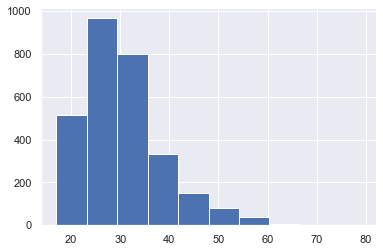

In [59]:
build_df['edad'].hist()

In [60]:
age_ranges = pd.qcut(build_df['edad'], 3)
age_ranges.unique().astype(str)

array(['(32.0, 79.0]', '(16.999, 26.0]', '(26.0, 32.0]'], dtype='<U14')

In [61]:
# Reemplazamos la variable "edad" por una categórica con "rangos de edad"
build_df['rango_edad'] = age_ranges.astype(str)
build_df['rango_edad'].value_counts()

(16.999, 26.0]    1017
(26.0, 32.0]      1000
(32.0, 79.0]       879
Name: rango_edad, dtype: int64

In [62]:
# Almacenamos los intervalos de edad
with open('output/age_ranges.pkl', 'wb') as f:
    pickle.dump(age_ranges.unique().tolist(), f)
    
# Eliminamos la columna edad
build_df = build_df.drop(columns=['edad'])

Esto lo hacemos dado que el comportamiento de endeudamiento cambia según la edad de las personas. Nótese el uso de pandas **qcut** para realizar este cálculo. Lo que hace es distribuir en categorías según los percentiles y nos da una interpretación más general de la edad.

#### Variable antiguedad

Tenemos actualmente los siguientes valores categóricos:
- Menos de 6 meses
- de 6 meses a 1 año
- mas de 1 año

Vamos a reemplazar **de 6 meses a 1 año** y **mas de 1 año** por **6 meses o mas**

In [63]:
build_df['Antiguedad'].value_counts()

Menos de 6 meses      2393
de 6 meses a 1 año     484
mas de 1 año            19
Name: Antiguedad, dtype: int64

In [64]:
antiquity_map = {
    'Menos de 6 meses': 'Menos de 6 meses',
    'de 6 meses a 1 año': '6 meses o mas',
    'mas de 1 año': '6 meses o mas',
}
antiquity_map

{'Menos de 6 meses': 'Menos de 6 meses',
 'de 6 meses a 1 año': '6 meses o mas',
 'mas de 1 año': '6 meses o mas'}

In [65]:
build_df['Antiguedad'] = build_df['Antiguedad'].map(antiquity_map)
build_df['Antiguedad'].value_counts()

Menos de 6 meses    2393
6 meses o mas        503
Name: Antiguedad, dtype: int64

#### Variable MOP Historico

Los valores categóricos oficiales por los cuales se cambiaran son:
- Nulos: Sin registro
- N: Al día
- 1: Mora 30 días
- 2: Mora 60 días
- 3: Mora 90 días
- 4: Mora 120 días
- 5, 6: Mora > 120 días

A pesar de lo anterior, vamos a agrupar según el análisis exploratorio, donde encontramos que solo dos categorías de MOP tienen valor en la decisión por tanto, vamos a generar una tercera para agrupar el resto de los datos:
- Nulos: Sin registro
- N: Al día
- 1, 2, 3, 4: Mora 30 a 120 días
- 5, 6: Mora > 120 días

In [66]:
build_df['mop_historico'].value_counts()

N    2282
6     359
4      34
5      18
2      13
3      11
1       4
Name: mop_historico, dtype: int64

In [67]:
mop_map = {
    'N': 'Al día',
    '1': 'Mora 30 a 120 días',
    '2': 'Mora 30 a 120 días',
    '3': 'Mora 30 a 120 días',
    '4': 'Mora 30 a 120 días',
    '5': 'Mora > 120 días',
    '6': 'Mora > 120 días',
}
mop_map

{'N': 'Al día',
 '1': 'Mora 30 a 120 días',
 '2': 'Mora 30 a 120 días',
 '3': 'Mora 30 a 120 días',
 '4': 'Mora 30 a 120 días',
 '5': 'Mora > 120 días',
 '6': 'Mora > 120 días'}

In [68]:
build_df['mop_historico'] = build_df['mop_historico'].map(mop_map)
build_df['mop_historico'] = build_df['mop_historico'].fillna('Sin registro')
build_df['mop_historico'].value_counts()

Al día                2282
Mora > 120 días        377
Sin registro           175
Mora 30 a 120 días      62
Name: mop_historico, dtype: int64

#### Variable perfil de usuario

Esta variable se calculará según el valor del **score**. A continuación se indican las transformaciones que se deben realizar a modo de rangos de score creditício:

- Nulos: Sin registro
- score = 1: Usuario en quiebra
- score = 7: Joven
- 150 <= score < 400: Bajo
- 400 <= score < 700: Medio
- 700 <= score < INF: Alto

[Referencia](https://qiip.com.co/es/blog/que-significa-tener-un-buen-puntaje-en-datacredito#:~:text=En%20Datacr%C3%A9dito%20el%20puntaje%20crediticio,de%20las%20obligaciones%20financieras%20pendientes)

<AxesSubplot:>

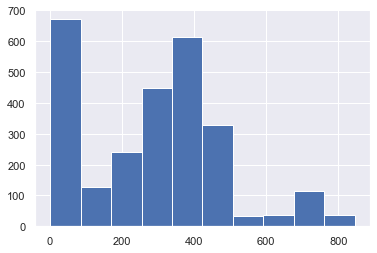

In [69]:
build_df['score'].hist()

In [70]:
def build_user_profile(value):
    if value == 1:
        return 'Usuario en quiebra'
    elif value == 7:
        return 'Joven'
    elif value >= 150 and value < 400:
        return 'Bajo'
    elif value >= 400 and value < 700:
        return 'Medio'
    elif value >= 700:
        return 'Alto'
    else:
        return 'Sin registro'
    
build_df['perfil_usuario'] = build_df['score'].apply(build_user_profile)
build_df['perfil_usuario'].value_counts()

Bajo                  1238
Usuario en quiebra     641
Medio                  613
Sin registro           246
Alto                   130
Joven                   28
Name: perfil_usuario, dtype: int64

In [71]:
build_df = build_df.drop(columns=['score'])

#### Variable Garantia

Vamos a convertir esta variable en catagoría así:

- 0: Sin garantia
- 1: Tipo garantia 1
- 2: Tipo garantia 2

In [72]:
build_df['Garantia'].value_counts()

2.0    2162
1.0     734
Name: Garantia, dtype: int64

In [73]:
garantia_map = {
    0.0: 'Sin garantia',
    1.0: 'Tipo garantia 1',
    2.0: 'Tipo garantia 2',
}
garantia_map

{0.0: 'Sin garantia', 1.0: 'Tipo garantia 1', 2.0: 'Tipo garantia 2'}

In [74]:
build_df['Garantia'] = build_df['Garantia'].map(garantia_map)
build_df['Garantia'] = build_df['Garantia'].fillna('Sin garantia')
build_df['Garantia'].value_counts()

Tipo garantia 2    2162
Tipo garantia 1     734
Name: Garantia, dtype: int64

### Verificación de los datos

In [75]:
build_df.columns

Index(['Y', 'genero', 'Antiguedad', 'Creditos', 'saldo_actual',
       'saldo_vencido', 'mop_historico', 'Promedio de limite_credito',
       'Promedio de credito_maximo', 'Promedio de cantidad_cuotas',
       'Promedio de valor_cuota', 'ahorro_impacto',
       'bienestar_financiero_impacto', 'coaching_impacto', 'monto_ahorro',
       'monto_total', 'Garantia', 'rango_edad', 'perfil_usuario'],
      dtype='object')

In [76]:
target_column = ['Y']

categorical_columns = [
    'genero', 'rango_edad', 'Antiguedad', 'mop_historico', 'perfil_usuario', 'Garantia',
]

numerical_columns = [
    'Creditos', 'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 
    'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'monto_ahorro', 'monto_total',
]

In [77]:
len(target_column + categorical_columns + numerical_columns)

19

In [78]:
build_df.columns.shape[0]

19

Lo anterior certifica que la cantidad de variables previstas en los listados coincide con los datos en el objeto de pandas.

In [79]:
build_df = build_df[target_column + categorical_columns + numerical_columns]
build_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Y                             2896 non-null   int64  
 1   genero                        2896 non-null   object 
 2   rango_edad                    2896 non-null   object 
 3   Antiguedad                    2896 non-null   object 
 4   mop_historico                 2896 non-null   object 
 5   perfil_usuario                2896 non-null   object 
 6   Garantia                      2896 non-null   object 
 7   Creditos                      2896 non-null   int64  
 8   saldo_actual                  2896 non-null   float64
 9   saldo_vencido                 2896 non-null   float64
 10  Promedio de limite_credito    2896 non-null   float64
 11  Promedio de credito_maximo    2896 non-null   float64
 12  Promedio de cantidad_cuotas   2896 non-null   float64
 13  Pro

In [80]:
temp_df = pd.DataFrame(build_df.isna().sum()).reset_index()
temp_df.columns = ['column', 'is_null']
temp_df[temp_df.is_null > 0].size

0

Concluímos que todas las variables han sido categorizadas correctamente y se han imputado valores para una fase de modelado adecuada. A continuación, vamos a analizar relaciones entre las variables, se realizará un proceso de selección de características y balanceo de datos con especial enfasis en la variable objetivo.

## 3. Selección de características y balanceo de datos

In [81]:
select_df = build_df.copy()

### Homologación tipos de datos

Realizaremos un proceso donde vamos a separar variables categóricas (representadas por cadenas de caracteres), variables enteras de representación booleana (0 y 1), variables enteras discretas y variables flotantes continuas. Esta distinción se hace especialmente para estudiar relaciones entre las variables, buscando identificar aquellas que "posiblemente" no tengan relevancia en el modelado.

In [82]:
print(numerical_columns)

['Creditos', 'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'monto_ahorro', 'monto_total']


In [83]:
type_numerical_columns = [
    'int64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'int64', 'int64', 'int64', 'float64', 'float64'
]

for i, column in enumerate(numerical_columns):
    select_df[column] = \
        select_df[column].astype(type_numerical_columns[i])

select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Y                             2896 non-null   int64  
 1   genero                        2896 non-null   object 
 2   rango_edad                    2896 non-null   object 
 3   Antiguedad                    2896 non-null   object 
 4   mop_historico                 2896 non-null   object 
 5   perfil_usuario                2896 non-null   object 
 6   Garantia                      2896 non-null   object 
 7   Creditos                      2896 non-null   int64  
 8   saldo_actual                  2896 non-null   float64
 9   saldo_vencido                 2896 non-null   float64
 10  Promedio de limite_credito    2896 non-null   float64
 11  Promedio de credito_maximo    2896 non-null   float64
 12  Promedio de cantidad_cuotas   2896 non-null   float64
 13  Pro

### Verificación características correlacionadas

Vamos a considerar que un valor de correlación **< 0.8** o **> 0.8**, usando el método de Pearson, permite filtrar las columnas con una posible relación significativa y por tanto, esas variables serán consideradas en una validación posterior usando *p-value* (valor de significancia o relevancia de la relación).

In [84]:
lower_threshold, upper_threshold = -0.8, 0.8

In [85]:
numerical_corr_columns = []

for i, r in select_df[numerical_columns].corr(method='pearson').reset_index().iterrows():
    for c in numerical_columns:
        if c != r['index'] and (r[c] < lower_threshold or r[c] > upper_threshold):
            if c not in numerical_corr_columns:
                numerical_corr_columns.append(c)
            
len(numerical_corr_columns)

0

In [86]:
if len(numerical_corr_columns) > 0:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(select_df[numerical_corr_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)
else:
    print("¡No se evalúan correlaciones!")

¡No se evalúan correlaciones!


<!-- Dado el mapa de calor anterior, logramos identificar características que tienen correlaciones fuertes, es decir, sospechamos que tengan una relación pero no confirmada. En este punto, vamos a estudiar las distribuciones por grupos de variables y trataremos de comprender estadisticamente si realmente algunas de las variables las podemos descartar dado que tienen una relación significativa. -->

In [87]:
# numerical_corr_columns = []

# for i, r in select_df[numerical_columns].corr(method='pearson').reset_index().iterrows():
#     for c in numerical_columns:
#         if c != r['index'] and (r[c] < lower_threshold or r[c] > upper_threshold):
#             if c not in [k['column'] for k in numerical_corr_columns] \
#                 and (r['index'], c) not in [(k['index'], k['column']) for k in numerical_corr_columns] \
#                 and (r['index'], c) not in [(k['column'], k['index']) for k in numerical_corr_columns]:
#                 numerical_corr_columns.append({
#                     "index": r['index'], "column": c, "value": r[c]
#                 })
            
# corr2_df = pd.DataFrame(numerical_corr_columns)
# corr2_df

<!-- Como podemos notar en la tabla, existen variables que por su fuerte correlación amerita realizar un estudio más a fondo y verificar si existe o no una relación. Para lograr esto, buscamos que el **p-value** sea menor que **0.05**, en ese caso se concluye que la relación es estadísticamente significativa. -->

In [88]:
# def pearson_and_pvalue(list1, list2):
#     pearson, pvalue = pearsonr(list1, list2)
#     return round(pearson, 2), round(pvalue, 6)

# corr2_df['complete'] = corr2_df.apply(
#     lambda r: pearson_and_pvalue(select_df[r["index"]], select_df[r["column"]]), 
#     axis=1
# )
# corr2_df

<!-- Lo anterior indica que todas las relaciones estudiadas tienen un **p-value** por debajo del **0.05** y por tanto, todas son estadísticamente significativas. Vamos a seleccionar aquellas variables que por concepto de negocio realmente podrían ser descartadas del modelado, más por su significancia en negocio que de forma numérica. -->

In [89]:
# sns.pairplot(select_df[target_column + ['saldo_actual', 'Consumo_saldo_actual']])

<!-- **saldo_actual vs. Consumo_saldo_actual:** Vemos que la distribución marca una clara tendencia en ambas variables, pero se notan algunos factores de dispersión que hace sospechar que su relación no sea tan fuerte desde negocio y que algunos valores salgan de la tendencia lineal. Se conservarán ambas variables. -->

### Construcción de variables dummy (categóricas a matriz dispersa)

En este proceso vamos a convertir las variables categóricas en características dummy, es decir, las vamos a transformar en una matriz dispera de ceros y unos, donde cada valor se convierte en una columna con un indicador 0 o 1. Esto se realizará para poder ejecutar modelos, ya que estos algorítmos no comprender las variables de este tipo.

In [90]:
select2_df = select_df.copy()

In [91]:
select2_df = pd.get_dummies(select2_df, columns=categorical_columns)
select2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Y                                  2896 non-null   int64  
 1   Creditos                           2896 non-null   int64  
 2   saldo_actual                       2896 non-null   float64
 3   saldo_vencido                      2896 non-null   float64
 4   Promedio de limite_credito         2896 non-null   float64
 5   Promedio de credito_maximo         2896 non-null   float64
 6   Promedio de cantidad_cuotas        2896 non-null   float64
 7   Promedio de valor_cuota            2896 non-null   float64
 8   ahorro_impacto                     2896 non-null   int64  
 9   bienestar_financiero_impacto       2896 non-null   int64  
 10  coaching_impacto                   2896 non-null   int64  
 11  monto_ahorro                       2896 non-null   float

In [92]:
print(target_column)

['Y']


In [93]:
features_columns = select2_df.columns.tolist()[1:]
print(features_columns)

['Creditos', 'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'monto_ahorro', 'monto_total', 'genero_FEMENINO', 'genero_MASCULINO', 'genero_OTRO', 'rango_edad_(16.999, 26.0]', 'rango_edad_(26.0, 32.0]', 'rango_edad_(32.0, 79.0]', 'Antiguedad_6 meses o mas', 'Antiguedad_Menos de 6 meses', 'mop_historico_Al día', 'mop_historico_Mora 30 a 120 días', 'mop_historico_Mora > 120 días', 'mop_historico_Sin registro', 'perfil_usuario_Alto', 'perfil_usuario_Bajo', 'perfil_usuario_Joven', 'perfil_usuario_Medio', 'perfil_usuario_Sin registro', 'perfil_usuario_Usuario en quiebra', 'Garantia_Tipo garantia 1', 'Garantia_Tipo garantia 2']


In [94]:
len(features_columns)

32

### Selección de características relevantes

A continuación realizaremos un par de procesos que nos permitirán intuir que variables son más relevantes para el modelado. Por un lado, vamos a ejecutar una **eliminación recursiva de características** con el fin de descartar aquellas variables que aportan poco al modelo. En segundo lugar, intentaremos con una **eliminación por importancia** usando un modelo de Árboles de decisión, clasificando las variables según su influencia en el modelado.

In [95]:
X, y = select2_df[features_columns], select2_df[target_column]

#### Eliminación recursiva de características

Utilizando un procedimiento de modelado inicial con **Regresión Logística**, vamos a seleccionar las variables más importantes del conjunto de datos realizando una **eliminación recursiva** hasta dejar una cantidad de variables que tengan un aporte realmente significativo. El modelo será usado con soporte para datos desbalanceados.

In [96]:
def get_rfe_analysis(X, y, feature_list):
    score_list, support_list = [], []
    for n_features in feature_list:
        model = LogisticRegression(random_state=1, class_weight="balanced")
        selector = RFE(estimator=model, n_features_to_select=n_features)
        selector.fit(X, y)
        score_list.append(selector.score(X, y))
        support_list.append(selector.support_)
    result_dict = {
        "label": feature_list,
        "score": score_list,
        "support": support_list,
    }
    return pd.DataFrame(result_dict)

<AxesSubplot:xlabel='label', ylabel='score'>

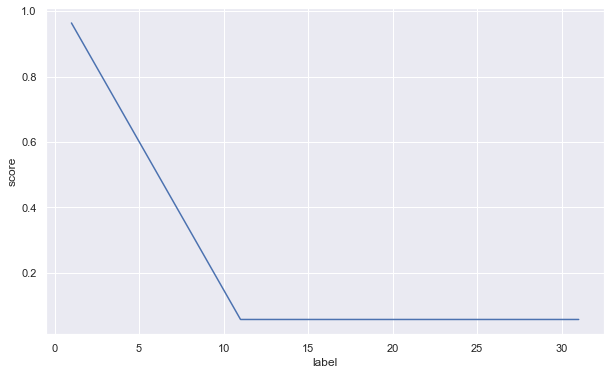

In [97]:
result_1 = get_rfe_analysis(X, y, feature_list=list(range(1, len(features_columns)+1, 10)))

f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=result_1, x='label', y='score', ax=ax)

Dado el resultado anterior, debemos descartar el método de eliminación recursiva, ya que no arroja resultados coherentes con respecto a cuantas características eliminar del conjunto de datos que garantice la mejor precisión.

### Eliminación de características por importancia

Realizaremos un proceso de **eliminación de variables usando un modelo Ensemble**, en este caso **Random Forest**, para encontrar características que sean mucho más significativas para el modelado. Nuestro objetivo es tratar de dejar solo el 50% de las variables con dos finalidades: la primera es evitar sobreajustes en el modelado y la segunda es para volver más eficiente, computacionalmente, el modelamiento.

Dado que la variable objetivo esta desbalanceada, vamos a ejecutar el modelado usando ajuste del parámetro **pesos de las clases**, con el fin de evitar problemas de ajuste en la clase minoritaria.

In [98]:
model_ = RandomForestClassifier(random_state=1, class_weight='balanced')
model_.fit(X, y)

feature_names = np.array(X.columns)
feature_importances = pd.Series(model_.feature_importances_)

# Calculamos más percentiles para apreciar mejor los cambios entre ellos
feature_importances_desc = feature_importances.describe()

feature_importances_desc

count    32.000000
mean      0.031250
std       0.049928
min       0.000071
25%       0.004803
50%       0.009807
75%       0.020112
max       0.216003
dtype: float64

<AxesSubplot:>

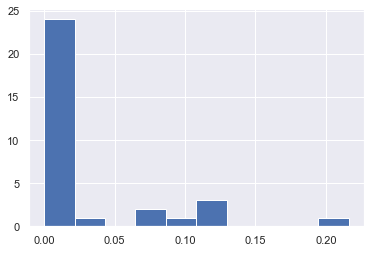

In [99]:
feature_importances.hist()

A partir del percentil **25%** se comienzan a apreciar los valores de importancia más altos y significativos con respecto a los percentiles por debajo de este. En comparación con la **media** que es mucho más alta, dada la variabilidad de la distribución y la asimetría que presenta, con una cola pesada a la derecha, es mejor decisión utilizar la mediana como medida de tendencia central. Usaremos esta métrica para configurar el algoritmo de **selección de características**.

In [100]:
selector = SelectFromModel(model_, threshold=feature_importances_desc['25%'])
selector.fit(X, y)

len(feature_names[selector.get_support()])

24

In [101]:
ife_columns = feature_names[selector.get_support()]
print(ife_columns)

['Creditos' 'saldo_actual' 'saldo_vencido' 'Promedio de limite_credito'
 'Promedio de credito_maximo' 'Promedio de cantidad_cuotas'
 'Promedio de valor_cuota' 'genero_FEMENINO' 'genero_MASCULINO'
 'rango_edad_(16.999, 26.0]' 'rango_edad_(26.0, 32.0]'
 'rango_edad_(32.0, 79.0]' 'Antiguedad_6 meses o mas'
 'Antiguedad_Menos de 6 meses' 'mop_historico_Al día'
 'mop_historico_Mora > 120 días' 'perfil_usuario_Alto'
 'perfil_usuario_Bajo' 'perfil_usuario_Joven' 'perfil_usuario_Medio'
 'perfil_usuario_Sin registro' 'perfil_usuario_Usuario en quiebra'
 'Garantia_Tipo garantia 1' 'Garantia_Tipo garantia 2']


#### Eliminación de características por importancia regresión logística

In [149]:
model_lr = LogisticRegression(random_state=0, class_weight='balanced')
model_lr.fit(X, y)

feature_names = np.array(X.columns)
feature_importances = pd.Series(np.round(model_lr.coef_[0], decimals=20))

# Calculamos más percentiles para apreciar mejor los cambios entre ellos
feature_importances_desc = feature_importances.describe()

feature_importances_desc

count    3.200000e+01
mean     5.838923e-08
std      3.944829e-07
min     -8.307344e-07
25%     -2.064305e-09
50%     -9.176963e-10
75%     -3.621926e-12
max      1.994602e-06
dtype: float64

<AxesSubplot:>

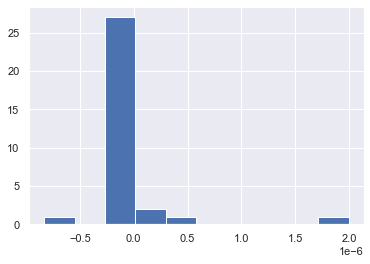

In [150]:
feature_importances.hist()

In [152]:
selector = SelectFromModel(model_lr, threshold=feature_importances_desc['50%'])
selector.fit(X, y)

len(feature_names[selector.get_support()])

32

In [105]:
ife_lr_columns = feature_names[selector.get_support()]
print(ife_lr_columns)

['Creditos' 'saldo_actual' 'saldo_vencido' 'Promedio de limite_credito'
 'Promedio de credito_maximo' 'Promedio de cantidad_cuotas'
 'Promedio de valor_cuota' 'ahorro_impacto' 'bienestar_financiero_impacto'
 'coaching_impacto' 'monto_ahorro' 'monto_total' 'genero_FEMENINO'
 'genero_MASCULINO' 'genero_OTRO' 'rango_edad_(16.999, 26.0]'
 'rango_edad_(26.0, 32.0]' 'rango_edad_(32.0, 79.0]'
 'Antiguedad_6 meses o mas' 'Antiguedad_Menos de 6 meses'
 'mop_historico_Al día' 'mop_historico_Mora 30 a 120 días'
 'mop_historico_Mora > 120 días' 'mop_historico_Sin registro'
 'perfil_usuario_Alto' 'perfil_usuario_Bajo' 'perfil_usuario_Joven'
 'perfil_usuario_Medio' 'perfil_usuario_Sin registro'
 'perfil_usuario_Usuario en quiebra' 'Garantia_Tipo garantia 1'
 'Garantia_Tipo garantia 2']


In [124]:
ife_columns == ife_lr_columns

False

En conclusión, luego de todo el proceso de **selección de características**, se decide utilizar el método de **eliminación por importancia** realizado con el modelo RandomForest y SelectFromModel que nos deja las **24 variables** con mayor nivel de importancia.

<!-- **NOTA IMPORTANTE:** Vamos a ignorar la eliminación de características y trabajaremos con todas para ir ajustando el modelo . -->

In [191]:
select_final_df = select2_df.copy()
# select_final_df = select2_df.copy()[ife_columns]
# select_final_df = select2_df.copy()[ife_lr_columns]
select_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Y                                  2896 non-null   int64  
 1   Creditos                           2896 non-null   int64  
 2   saldo_actual                       2896 non-null   float64
 3   saldo_vencido                      2896 non-null   float64
 4   Promedio de limite_credito         2896 non-null   float64
 5   Promedio de credito_maximo         2896 non-null   float64
 6   Promedio de cantidad_cuotas        2896 non-null   float64
 7   Promedio de valor_cuota            2896 non-null   float64
 8   ahorro_impacto                     2896 non-null   int64  
 9   bienestar_financiero_impacto       2896 non-null   int64  
 10  coaching_impacto                   2896 non-null   int64  
 11  monto_ahorro                       2896 non-null   float

In [192]:
# Repisamos el valor de la X original
X = select_final_df

feature_names = np.array(X.columns)

X.shape, feature_names.shape

((2896, 33), (33,))

In [193]:
with open('output/columns.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

### Balanceo datos en variable objetivo

In [194]:
y.Y.value_counts() / y.shape[0]

0    0.970649
1    0.029351
Name: Y, dtype: float64

<AxesSubplot:xlabel='Y', ylabel='count'>

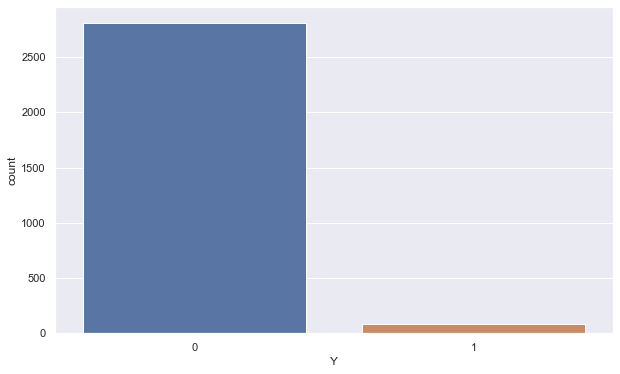

In [195]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x=y.Y, ax=ax)

Como se puede apreciar, hay un desbalance notable entre las personas que fueron **Aceptadas** y **Rechazadas**. Los aceptados apenas suman el 3% de la población. Dado lo anterior, vamos a buscar una forma de adecuada de balancear los datos para el proceso de entrenamiento sin desmejorar las condiciones del mismo, dado que un estimador para la clase **Aceptadas** es probable que no funcione bien o no prediga bien una observación nueva.

Iniciaremos entonces a estudiar algunas **estrategías de balanceo** de nuestra variable objetivo hasta determinar la mejor opción de modelado, es decir, los mejores parámetros para un modelado confiable y con alta precisión en nuestra muestra desbalanceada. Propongo las siguientes dos técnicas:

* **Ajustando parámetros de pesos de los modelos de clasificación**, por ejemplo, la regresión logística cumple este propósito. Tiene un parámetro para balanceo de las clases y abstrae esta implementación. Random Forest tiene la misma característica.

* **Ensamble de métodos balanceados** que utiliza las ventajas de los modelos tipo Ensemble para entrenar y luego decide por "votación" el resultado final, usando al mismo tiempo estrategías de balanceo de clases.

* **Combinación de Resampling con Smote-Tomek** que nos permite en simultáneo realizar un subsampling en la clase mayoritaría **Rechazado** y un oversampling en la minoritaría **Aceptado** (usando vecinos más cercanos agrega puntos en línea recta). El algoritmo de **Tomek** lo usaremos para undersampling que quita los bordes y deja ver mejor la frontera entre las clases.

**NOTA:** Otra alternativa es **modificar el conjunto de datos y equilibrar las clases**, pero esto es peligroso dado que los datos de la clase minoritaria son muy pocos y estaremos eliminando muestras importantes para el entrenamiento. Por otro lado, podemos aplicar **generación de muestras artificiales o sintéticas**, pero en este caso, y dado que la clase minoritaria es tan insuficiente, podemos alterar demasiado la distribución de los datos al tratar de aumentar tanto una de las clases, considerando que no queremos sacrificar datos de la clase mayoritaría.

### Preparación datos de entrenamiento y prueba

Se realizará un particionamiento de los datos, 70% para entrenar y 30% para evaluar los modelos. Por otro lado, se elaborarán unas funciones para ejecutar los estimadores requeridos, ejecutando un Pipeline con un escalador (estandarizador de las unidades en las variables) de datos llamado RobustScaler sobre las variables discretas y continuas (es más sensible a datos atípicos).

In [207]:
scaler_types = pd.DataFrame(X.dtypes.astype(str), columns=['type'])
scaler_columns = scaler_types[scaler_types.type.isin(['int64', 'float64'])].index.tolist()

x_scaled = X.copy()
x_scaled_types = x_scaled[scaler_columns]
x_scaled_types = pd.DataFrame(RobustScaler().fit_transform(x_scaled_types), columns=scaler_columns)

for col in scaler_columns:
    x_scaled[col] = x_scaled_types[col]
    
x_scaled.describe()

,Y,Creditos,saldo_actual,saldo_vencido,Promedio de limite_credito,Promedio de credito_maximo,Promedio de cantidad_cuotas,Promedio de valor_cuota,ahorro_impacto,bienestar_financiero_impacto,...,mop_historico_Mora > 120 días,mop_historico_Sin registro,perfil_usuario_Alto,perfil_usuario_Bajo,perfil_usuario_Joven,perfil_usuario_Medio,perfil_usuario_Sin registro,perfil_usuario_Usuario en quiebra,Garantia_Tipo garantia 1,Garantia_Tipo garantia 2
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,...,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.00000,2896.000000,2896.000000
mean,0.029351,0.506474,1.015526,1.146240,2.542251,0.827485,0.677306,1.211044,0.011740,0.001036,...,0.130180,0.060428,0.044890,0.427486,0.009669,0.211671,0.084945,0.22134,0.253453,0.746547
std,0.168817,1.779046,3.870665,6.138100,8.922981,3.592529,2.154868,6.579611,0.107733,0.032174,...,0.336559,0.238320,0.207097,0.494799,0.097869,0.408564,0.278848,0.41522,0.435063,0.435063
min,0.000000,-0.750000,-0.353133,-0.424338,0.000000,-0.232758,-0.447709,-0.448453,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,-0.250000,-0.222546,-0.277991,0.000000,-0.232758,-0.188527,-0.299595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,0.000000,0.750000,0.777454,0.722009,1.000000,0.767242,0.811473,0.700405,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,1.000000,29.250000,115.421873,214.943233,248.344371,142.002088,66.149003,170.484479,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [208]:
# Nombres de las clases
LABELS = ["rejected", "accepted"]

# Hacemos un split datos de entrenamiento y pruebas
# Dejamos 70% para entrenar y 30% para pruebas
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, train_size=0.7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2027, 33), (869, 33), (2027, 1), (869, 1))

In [198]:
def run_model(X_train, X_test, y_train, y_test, estimator):
    model = Pipeline([('estimator', estimator)])
    model.fit(X_train, y_train)
    return model, model.predict(X_test)

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test, pred_y))

## 4. Modelamiento con Regresión Logística

En primera instancia, vamos a utilizar el modelo **Logistic Regression** "a secas", es decir, lo ejecutamos sin parámetros de balanceo para poder apreciar las métricas de calidad y tomar decisiones con respecto a los parámetros que vamos a ajustar de ahí en adelante. Aplicaremos cada **estrategia de balanceo** con este modelo y en una fase posterior vamos a utilizar el modelo de **Random Forest** para comparar ambas técnicas.

#### Modelado inicial sin balanceo de datos

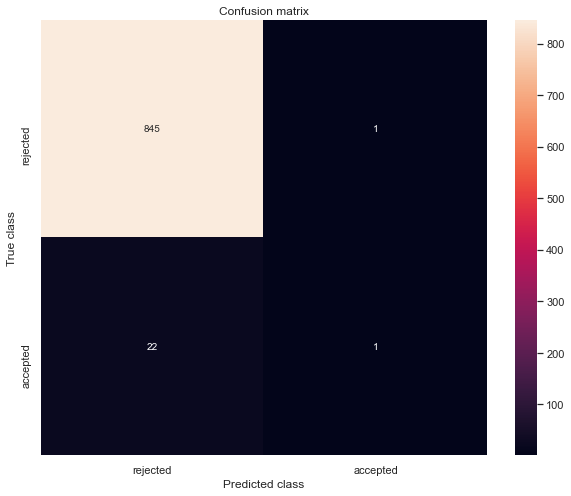

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       846
           1       0.50      0.04      0.08        23

    accuracy                           0.97       869
   macro avg       0.74      0.52      0.53       869
weighted avg       0.96      0.97      0.96       869



In [209]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=1))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 24 fallos y 0 aciertos con un **Recall** de **0%** (no tiene capacidad). Aunque el valor de Precision y Recall para la predicción de **Rechazado** es bastante bueno, debemos mejorar el valor obtenido para la clase minoritaría que es nuestro foco en los siguientes apartados.

#### Ajustando parámetros "peso de clase" en los modelos

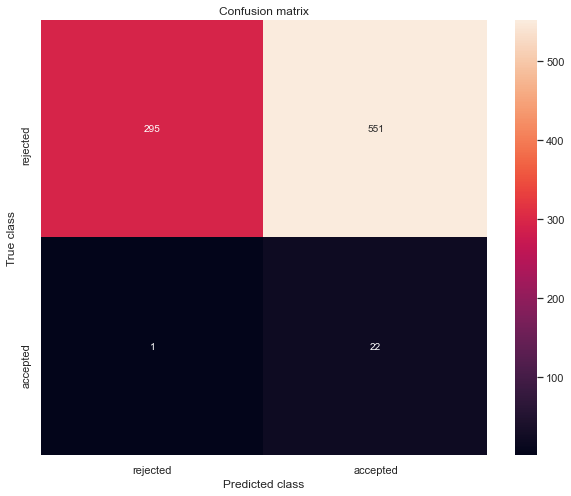

              precision    recall  f1-score   support

           0       1.00      0.35      0.52       846
           1       0.04      0.96      0.07        23

    accuracy                           0.36       869
   macro avg       0.52      0.65      0.30       869
weighted avg       0.97      0.36      0.50       869



In [210]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=0, class_weight="balanced"))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 8 fallos y 16 aciertos con un **Recall** de **67%** (bajo). Aunque el valor de Recall para la predicción de **Rechazado** es bueno (80%), se nota una cantidad considerable de *Falsos Positivos* (170).

#### Ensamble de métodos balanceados

En este caso vamos a utilizar el modelo **Balanced Bagging** de la librería **imbalanced learn** el cual nos ofrece una abstracción bastante profunda de un modelo basado en "votación" en conjunto con una balanceo de las clases.

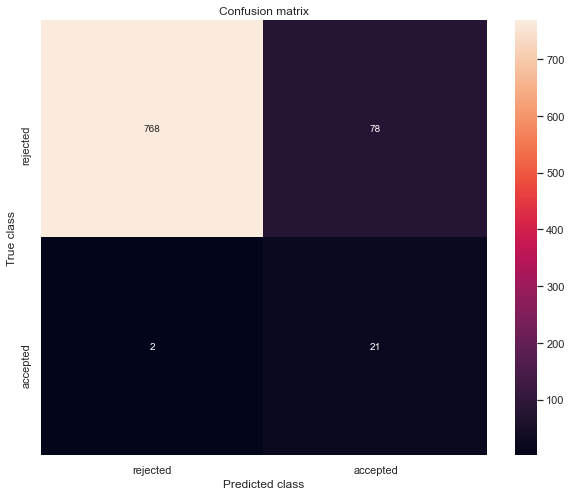

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       846
           1       0.21      0.91      0.34        23

    accuracy                           0.91       869
   macro avg       0.60      0.91      0.65       869
weighted avg       0.98      0.91      0.93       869



In [211]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=1), 
        sampling_strategy='auto', replacement=False, random_state=0))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 10 fallos y 14 aciertos con un **Recall** de **53%** (bajo). Aunque el valor de Recall para la predicción de **Rechazado** es aceptable (65%), se nota un valor considerable de *Falsos Positivos* (295).

#### Combinación Resampling con Smote-Tomek

Before resampling Counter({0: 1965, 1: 62})
After resampling Counter({0: 1956, 1: 1956})


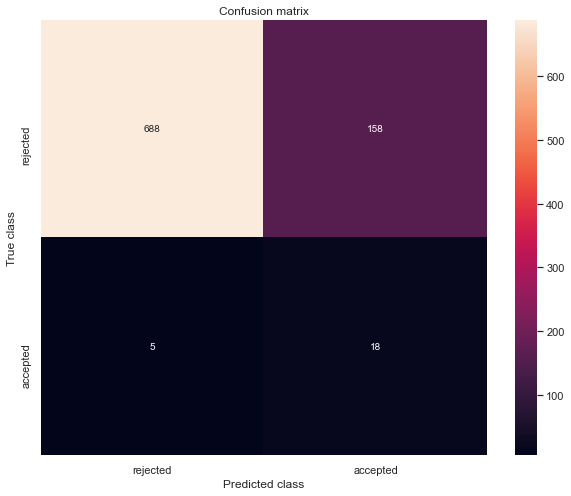

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       846
           1       0.10      0.78      0.18        23

    accuracy                           0.81       869
   macro avg       0.55      0.80      0.54       869
weighted avg       0.97      0.81      0.88       869



In [212]:
os_us = SMOTETomek(random_state=1)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Before resampling {}".format(Counter(y_train.Y)))
print ("After resampling {}".format(Counter(y_train_res.Y)))

model, pred_y = run_model(
    X_train_res, X_test, y_train_res, y_test, 
    LogisticRegression(random_state=1))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 20 fallos y 4 aciertos con un **Recall** de **17%** (bajo). El valor de Recall para la predicción de **Rechazado** es bueno (95%).

## 5. Modelamiento con Random Forest

Vamos a utilizar el modelo **Random Forest** "a secas". Aplicaremos cada **estrategia de balanceo** con este modelo.

#### Modelado inicial sin balanceo de datos

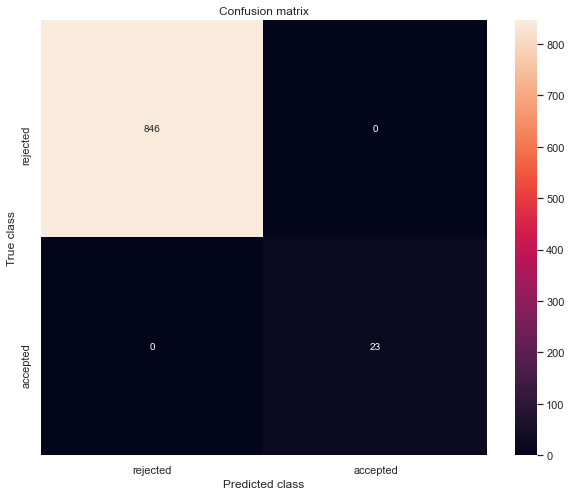

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00        23

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869



In [213]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    RandomForestClassifier(random_state=1))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 24 fallos y 0 aciertos con un **Recall** de **0%**, es decir, no es capaz de predecir esta clase. Aunque el valor de Recall para la predicción de **Rechazado** es del 100%, debemos mejorar el valor obtenido para la clase minoritaría que es nuestro foco en los siguientes apartados.

#### Ajustando parámetros "peso de clase" en los modelos

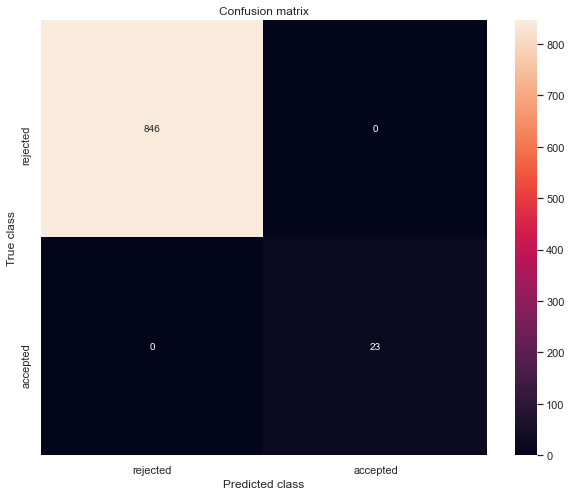

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00        23

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869



In [214]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    RandomForestClassifier(random_state=1, class_weight="balanced"))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 24 fallos y 0 aciertos con un **Recall** de **0%** (no tiene capacidad). El valor de Precision y Recall para la predicción de **Rechazado** es bueno (100%).

#### Ensamble de métodos balanceados

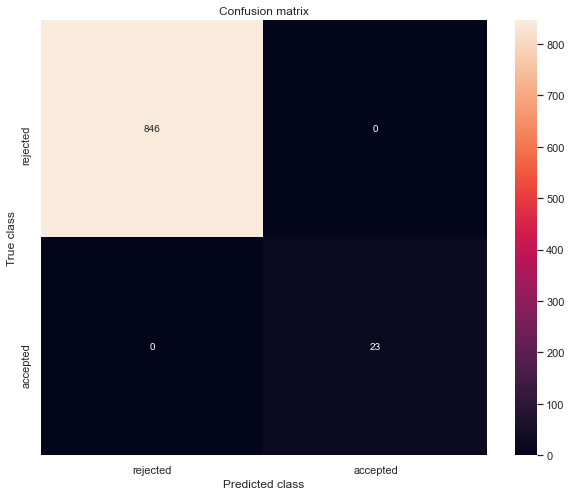

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00        23

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869



In [215]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=RandomForestClassifier(random_state=1), 
        sampling_strategy='auto', replacement=False, random_state=0))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 7 fallos y 17 aciertos con un **Recall** de **71%** (bueno). Aunque el valor de Recall para la predicción de **Rechazado** es bueno (88%), se nota un valor considerable de Falsos Positivos (102).

#### Combinación Resampling con Smote-Tomek

Before resampling Counter({0: 1966, 1: 61})
After resampling Counter({1: 1957, 0: 1957})


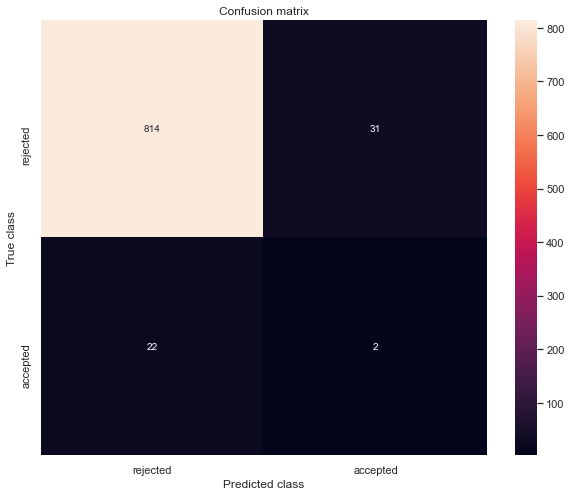

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       845
           1       0.06      0.08      0.07        24

    accuracy                           0.94       869
   macro avg       0.52      0.52      0.52       869
weighted avg       0.95      0.94      0.94       869



In [186]:
os_us = SMOTETomek(random_state=1)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Before resampling {}".format(Counter(y_train.Y)))
print ("After resampling {}".format(Counter(y_train_res.Y)))

model, pred_y = run_model(
    X_train_res, X_test, y_train_res, y_test, 
    RandomForestClassifier(random_state=1))

show_results(y_test, pred_y)

La clase **Aceptado** tiene 22 fallos y 2 aciertos con un **Recall** de **8%** (no tiene capacidad). El valor de Recall para la predicción de **Rechazado** es bueno (100%).

## 6. Definición y justificación de la mejor métrica

En conclusión el modelo de **Random Forest** usando **Bagging Classifier** como método de Ensamble por "votación", entrega el mejor balance en la calidad predictiva, tanto para la clase **Rechazado** como para la clase minoritaría **Aceptado**.

A partir del reporte de clasificación podemos notar que el **Recall** para **Rechazado** es de **88%** y para **Aceptado** es de **71%**, que son métricas bastante ajustadas dado el alto desbalance en los datos. Vemos que los **F1-score** son de **93%** y **24%**, respectivamente; que en comparación con los otros métodos aplicados, genera el mejor balance en términos de las métricas. En este caso el valor de **Accuracy** es de **87%** que es en esencia una métrica aceptable para las condiciones del modelado. Se intuye por tanto, que tenemos una **calidad bastante aceptable** a la hora de predecir la clase que permite clasificar los **usuarios que ingresan al programa de reparación de deudas**.

Es importante resaltar que los 24 usuarios correspondientes a la clase **Aceptado**, 7 son fallos y 17 aciertos en la predicción, generando un buen balance predictivo en términos de la clase positiva. Además, notamos que con este método se presentó la menor cantidad de **Falsos Positivos** con un valor de **102 usuarios**. En conclusión, se pueden aceptar los fallos en la predicción de **rechazados que ingresan al programa** en comparativa con una mejor calidad para predecir los **verdaderamente aceptados**.

#### Preparación y almacenamiento de modelo final

In [189]:
model_final, pred_y_final = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=RandomForestClassifier(random_state=1), 
        sampling_strategy='auto', replacement=False, random_state=0))

# Almacenamos el modelo en un archivo pickle
with open('output/model.pkl', 'wb') as f:
    pickle.dump(model_final, f)

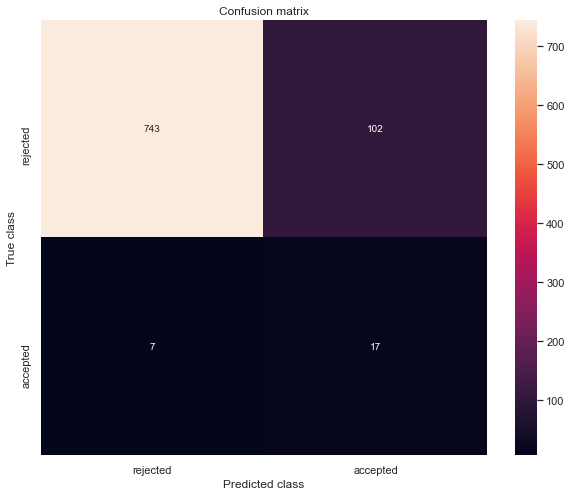

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       845
           1       0.14      0.71      0.24        24

    accuracy                           0.87       869
   macro avg       0.57      0.79      0.58       869
weighted avg       0.97      0.87      0.91       869



In [190]:
show_results(y_test, pred_y_final)